In [3]:
import matplotlib.cm as cm
import numpy as np
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from tqdm import tqdm
from epicare.envs import EpiCare
from epicare.policies import StandardOfCare, ClinicalTrial, Oracle, Random
from epicare.evaluations import run_episode
from sklearn.preprocessing import StandardScaler
from matplotlib.ticker import FixedLocator

from tueplots import bundles

plt.rcParams.update(bundles.neurips2024())
plt.rcParams["figure.dpi"] = 300

results_directory = "../algorithms/results/"

/home/masonhargrave/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-18 20:20:29.648629: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 20:20:29.648662: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 20:20:29.649807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 20:20:29.656072: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary 

## Tables

In [2]:
num_seeds = 8
num_episodes = 1000
results_directory = "../algorithms/results/"

all_data = []

for seed in tqdm(range(1, num_seeds + 1)):
    environment = EpiCare(seed=seed)

    # Setting up the policies
    policies = {
        "Random": Random(environment),
        "SMART": ClinicalTrial(environment),
        "SoC": StandardOfCare(environment, alpha=0.8),
        "OP": Oracle(environment),
    }

    # This dictionary will store the stats for each policy
    policy_stats = {}

    # Simulation loop
    for name, policy in policies.items():
        print(f"Running {name} policy")
        for episode in range(num_episodes):
            total_reward, time_to_remission, steps, transitions = (
                run_episode(
                    environment, policy, name, policy_stats, verbose=False
                )
            )
            policy_stats[name]["adverse_event"][-1] /= steps

        # After simulation, calculate averages and remission rates
        average_reward = np.mean(policy_stats[name]["total_rewards"]) * 100/64
        reward_std = np.std(policy_stats[name]["total_rewards"]) * 100/64
        remission_rate = np.mean(policy_stats[name]["remission"])
        average_time_to_remission = (
            np.mean(policy_stats[name]["times_to_remission"])
            if policy_stats[name]["times_to_remission"]
            else None
        )
        time_to_remission_std = (
            np.std(policy_stats[name]["times_to_remission"])
            if policy_stats[name]["times_to_remission"]
            else None
        )
        adverse_event_rate = np.mean(policy_stats[name]["adverse_event"])
        adverse_event_rate_std = np.std(policy_stats[name]["adverse_event"])
        # get sem
        adverse_event_rate_sem = adverse_event_rate_std / np.sqrt(num_episodes)

        # Adding data to all_data
        all_data.append(
            {
                "policy": name,
                "env_seed": seed,
                "mean_return": average_reward,
                "std_return": reward_std,
                "mean_time_to_remission": average_time_to_remission,
                "std_time_to_remission": time_to_remission_std,
                "mean_remission_rate": remission_rate,
                "mean_adverse_event_rate": adverse_event_rate,
                "sem_adverse_event_rate": adverse_event_rate_sem,
            }
        )

# Creating the final dataframe
df = pd.DataFrame(all_data)
# Saving separate CSV files for each policy
for policy in df["policy"].unique():
    # make policy name lowercase
    policy_df = df[df["policy"] == policy]
    policy_df = policy_df.drop(columns=["policy"])
    policy_df.to_csv(os.path.join(results_directory, f"{policy.lower()}_results.csv"), index=False)

  0%|          | 0/8 [00:00<?, ?it/s]

Running Random policy
Running SMART policy
Running SoC policy


  0%|          | 0/8 [00:04<?, ?it/s]

Running OP policy


KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np

models = ["op", "awac", "edac", "td3_bc", "cql-dqn", "iql", "dqn", "soc", "bc", "random"]
baseline = [True, False, False, False, False, False, False, False, True, True]
model_names = ["OP", "AWAC", "EDAC", "TD3+BC", "CQL", "IQL", "DQN", "SoC", "BC", "Random"]
model_mapping = dict(zip(models, model_names))
results = []
results_directory = "../algorithms/results/"

# Create a dictionary to store the results for each seed and model
seed_results = {}

for model in models:
    df = pd.read_csv(os.path.join(results_directory, f"{model}_results.csv"))
    # If "checkpoint" is a key, keep only rows where checkpoint_31 is the value
    if "checkpoint" in df.columns:
        df = df[df["checkpoint"] == "checkpoint_31.pt"]

    # Group results by env_seed
    grouped = df.groupby("env_seed")

    # Calculate mean and standard deviation of mean_return for each seed
    for seed, group in grouped:
        mean = group["mean_return"].mean()
        std = group["mean_return"].std()

        # Store the results in the dictionary
        if seed not in seed_results:
            seed_results[seed] = {}
        seed_results[seed][model] = (mean, std)

    # Calculate overall mean and standard deviation across seeds for the model
    overall_mean = df["mean_return"].mean()
    overall_std = df.groupby("env_seed")["mean_return"].std().mean()

    results.append((model, overall_mean, overall_std))

# Sort all models based on overall mean performance
results.sort(key=lambda x: x[1])

# Reorder to place baseline models first
sorted_results = [
    res for res in results if model_mapping[res[0]] in ["OP", "SoC", "Random"]
] + [res for res in results if model_mapping[res[0]] not in ["OP", "SoC", "Random"]]

# Generate LaTeX table
latex_table = "\\begin{tabular}{l" + "c" * len(models) + "}\n"
latex_table += (
    "& "
    + " & ".join([model_mapping[model] for model, _, _ in sorted_results])
    + " \\\\\n\\midrule\n"
)

# Add overall mean and standard deviation for each model
mean_row = ["Mean"]
for _, mean, std in sorted_results:
    if np.isnan(std):
        mean_row.append("{:.1f}".format(mean))
    else:
        mean_row.append("{:.1f} ({:.1f})".format(mean, std))
latex_table += " & ".join(mean_row) + " \\\\\n"

# Add mean and standard deviation for each seed
for seed in sorted(seed_results.keys()):
    seed_row = [f"Seed {seed}"]
    for model, _, _ in sorted_results:
        mean, std = seed_results[seed].get(
            model, (0, np.nan)
        )  # Default to (0, NaN) if not available
        if np.isnan(std):
            seed_row.append("{:.1f}".format(mean))
        else:
            seed_row.append("{:.1f} ({:.1f})".format(mean, std))
    latex_table += " & ".join(seed_row) + " \\\\\n"

latex_table += "\\bottomrule\n\\end{tabular}"

print(latex_table)

\begin{tabular}{lcccccccccc}
& Random & SoC & OP & EDAC & AWAC & BC & TD3+BC & IQL & DQN & CQL \\
\midrule
Mean & -1.4 & 40.0 & 95.3 & 2.4 (15.9) & 17.1 (1.7) & 18.5 (1.7) & 52.3 (10.8) & 72.5 (1.0) & 75.2 (0.8) & 78.0 (0.9) \\
Seed 1 & 5.5 & 44.2 & 95.7 & 7.2 (17.5) & 30.1 (1.8) & 24.4 (1.0) & 71.3 (5.2) & 76.5 (0.7) & 77.0 (0.6) & 79.4 (0.7) \\
Seed 2 & -4.7 & 42.2 & 94.2 & 0.9 (4.1) & 19.4 (2.2) & 22.1 (2.5) & 68.9 (1.8) & 73.8 (1.7) & 75.6 (0.9) & 77.8 (0.3) \\
Seed 3 & -13.8 & 38.1 & 94.9 & -6.2 (31.5) & 8.0 (1.1) & 11.0 (1.5) & 10.6 (22.2) & 68.5 (1.8) & 72.4 (1.3) & 75.6 (0.8) \\
Seed 4 & 2.0 & 34.6 & 95.8 & 2.6 (12.0) & 20.0 (1.0) & 20.4 (1.9) & 69.2 (1.5) & 71.0 (0.8) & 75.8 (1.4) & 78.8 (1.2) \\
Seed 5 & 6.6 & 35.8 & 95.6 & -4.9 (14.1) & 21.4 (2.1) & 22.0 (1.2) & 36.5 (24.8) & 72.1 (0.7) & 74.1 (0.6) & 78.2 (1.0) \\
Seed 6 & 0.7 & 43.8 & 95.9 & 6.7 (11.4) & 22.2 (3.2) & 18.5 (3.1) & 57.6 (8.8) & 72.9 (0.7) & 78.2 (0.5) & 80.0 (0.5) \\
Seed 7 & -3.6 & 44.0 & 95.2 & 0.1 (20.8) 

In [5]:
import pandas as pd
import numpy as np

models = [
    "op",
    "awac",
    "edac",
    "td3_bc",
    "cql-dqn",
    "iql",
    "dqn",
    "soc",
    "bc",
    "random",
]
baseline = [True, False, False, False, False, False, False, False, True, True]
model_names = [
    "OP",
    "AWAC",
    "EDAC",
    "TD3+BC",
    "CQL",
    "IQL",
    "DQN",
    "SoC",
    "BC",
    "Random",
]
model_mapping = dict(zip(models, model_names))
results = []
results_directory = "../algorithms/results/"

# Create a dictionary to store the results for each seed and model
seed_results = {}

for model in models:
    df = pd.read_csv(os.path.join(results_directory, f"{model}_results.csv"))
    # If "checkpoint" is a key, keep only rows where checkpoint_31 is the value
    if "checkpoint" in df.columns:
        df = df[df["checkpoint"] == "checkpoint_31.pt"]

    # Group results by env_seed
    grouped = df.groupby("env_seed")

    # Calculate mean and standard deviation of mean_return for each seed
    for seed, group in grouped:
        mean = group["mean_time_to_remission"].mean()
        std = group["mean_time_to_remission"].std()

        # Store the results in the dictionary
        if seed not in seed_results:
            seed_results[seed] = {}
        seed_results[seed][model] = (mean, std)

    # Calculate overall mean and standard deviation across seeds for the model
    overall_mean = df["mean_time_to_remission"].mean()
    overall_std = df.groupby("env_seed")["mean_time_to_remission"].std().mean()

    results.append((model, overall_mean, overall_std))

# Sort all models based on overall mean performance
results.sort(key=lambda x: -x[1])

# Reorder to place baseline models first
sorted_results = [
    res for res in results if model_mapping[res[0]] in ["OP", "SoC", "Random"]
] + [res for res in results if model_mapping[res[0]] not in ["OP", "SoC", "Random"]]

# Generate LaTeX table
latex_table = "\\begin{tabular}{l" + "c" * len(models) + "}\n"
latex_table += (
    "& "
    + " & ".join([model_mapping[model] for model, _, _ in sorted_results])
    + " \\\\\n\\midrule\n"
)

# Add overall mean and standard deviation for each model
mean_row = ["Mean"]
for _, mean, std in sorted_results:
    if np.isnan(std):
        mean_row.append("{:.1f}".format(mean))
    else:
        mean_row.append("{:.1f}({:.1f})".format(mean, std))
latex_table += " & ".join(mean_row) + " \\\\\n"

# Add mean and standard deviation for each seed
for seed in sorted(seed_results.keys()):
    seed_row = [f"Seed {seed}"]
    for model, _, _ in sorted_results:
        mean, std = seed_results[seed].get(
            model, (0, np.nan)
        )  # Default to (0, NaN) if not available
        if np.isnan(std):
            seed_row.append("{:.1f}".format(mean))
        else:
            seed_row.append("{:.1f}({:.1f})".format(mean, std))
    latex_table += " & ".join(seed_row) + " \\\\\n"

latex_table += "\\bottomrule\n\\end{tabular}"

print(latex_table)

\begin{tabular}{lcccccccccc}
& Random & SoC & OP & BC & EDAC & TD3+BC & AWAC & DQN & CQL & IQL \\
\midrule
Mean & 4.0 & 3.3 & 1.1 & 3.7(0.0) & 3.3(0.7) & 2.9(0.2) & 2.9(0.1) & 2.7(0.1) & 2.4(0.0) & 2.4(0.0) \\
Seed 1 & 4.2 & 3.5 & 1.1 & 3.7(0.0) & 3.3(0.4) & 2.6(0.1) & 3.1(0.1) & 2.7(0.1) & 2.3(0.0) & 2.3(0.0) \\
Seed 2 & 3.9 & 3.4 & 1.1 & 3.5(0.0) & 3.8(0.4) & 2.5(0.1) & 2.3(0.1) & 2.5(0.1) & 2.3(0.0) & 2.3(0.1) \\
Seed 3 & 3.9 & 2.9 & 1.1 & 3.6(0.1) & 3.2(0.9) & 3.7(0.6) & 2.5(0.1) & 2.6(0.1) & 2.5(0.1) & 2.4(0.0) \\
Seed 4 & 4.1 & 3.2 & 1.1 & 3.6(0.1) & 3.6(1.3) & 3.0(0.2) & 3.1(0.0) & 2.7(0.0) & 2.5(0.1) & 2.4(0.1) \\
Seed 5 & 4.0 & 3.4 & 1.1 & 3.7(0.0) & 3.5(0.5) & 2.7(0.1) & 2.9(0.1) & 2.8(0.1) & 2.5(0.0) & 2.4(0.0) \\
Seed 6 & 3.9 & 3.7 & 1.1 & 3.7(0.0) & 2.7(0.9) & 3.0(0.1) & 3.3(0.1) & 2.7(0.0) & 2.5(0.0) & 2.5(0.0) \\
Seed 7 & 4.0 & 3.4 & 1.1 & 3.9(0.0) & 3.2(0.5) & 3.1(0.2) & 3.3(0.1) & 2.7(0.1) & 2.4(0.0) & 2.4(0.0) \\
Seed 8 & 4.2 & 3.3 & 1.1 & 3.7(0.1) & 3.3(0.9) & 2.9(0.

In [6]:
import pandas as pd
import numpy as np

models = [
    "op",
    "awac",
    "edac",
    "td3_bc",
    "cql-dqn",
    "iql",
    "dqn",
    "soc",
    "bc",
    "random",
]
baseline = [True, False, False, False, False, False, False, False, True, True]
model_names = [
    "OP",
    "AWAC",
    "EDAC",
    "TD3+BC",
    "CQL",
    "IQL",
    "DQN",
    "SoC",
    "BC",
    "Random",
]
model_mapping = dict(zip(models, model_names))
results = []
results_directory = "../algorithms/results/"

# Create a dictionary to store the results for each seed and model
seed_results = {}

for model in models:
    df = pd.read_csv(os.path.join(results_directory, f"{model}_results.csv"))
    # If "checkpoint" is a key, keep only rows where checkpoint_31 is the value
    if "checkpoint" in df.columns:
        df = df[df["checkpoint"] == "checkpoint_31.pt"]

    # Group results by env_seed
    grouped = df.groupby("env_seed")

    # Calculate mean and standard deviation of mean_return for each seed
    for seed, group in grouped:
        mean = group["mean_remission_rate"].mean()
        std = group["mean_remission_rate"].std()

        # Store the results in the dictionary
        if seed not in seed_results:
            seed_results[seed] = {}
        seed_results[seed][model] = (mean, std)

    # Calculate overall mean and standard deviation across seeds for the model
    overall_mean = df["mean_remission_rate"].mean()
    overall_std = df.groupby("env_seed")["mean_remission_rate"].std().mean()

    results.append((model, overall_mean, overall_std))

# Sort all models based on overall mean performance
results.sort(key=lambda x: x[1])

# Reorder to place baseline models first
sorted_results = [
    res for res in results if model_mapping[res[0]] in ["OP", "SoC", "Random"]
] + [res for res in results if model_mapping[res[0]] not in ["OP", "SoC", "Random"]]

# Generate LaTeX table
latex_table = "\\begin{tabular}{l" + "c" * len(models) + "}\n"
latex_table += (
    "& "
    + " & ".join([model_mapping[model] for model, _, _ in sorted_results])
    + " \\\\\n\\midrule\n"
)

# Add overall mean and standard deviation for each model
mean_row = ["Mean"]
for _, mean, std in sorted_results:
    if np.isnan(std):
        mean_row.append("{:.2f}".format(mean))
    else:
        mean_row.append("{:.2f}({:.2f})".format(mean, std))
latex_table += " & ".join(mean_row) + " \\\\\n"

# Add mean and standard deviation for each seed
for seed in sorted(seed_results.keys()):
    seed_row = [f"Seed {seed}"]
    for model, _, _ in sorted_results:
        mean, std = seed_results[seed].get(
            model, (0, np.nan)
        )  # Default to (0, NaN) if not available
        if np.isnan(std):
            seed_row.append("{:.2f}".format(mean))
        else:
            seed_row.append("{:.2f}({:.2f})".format(mean, std))
    latex_table += " & ".join(seed_row) + " \\\\\n"

latex_table += "\\bottomrule\n\\end{tabular}"

print(latex_table)

\begin{tabular}{lcccccccccc}
& Random & SoC & OP & EDAC & AWAC & BC & TD3+BC & IQL & DQN & CQL \\
\midrule
Mean & 0.46 & 0.72 & 1.00 & 0.47(0.12) & 0.55(0.01) & 0.59(0.01) & 0.80(0.07) & 0.91(0.01) & 0.94(0.00) & 0.95(0.00) \\
Seed 1 & 0.51 & 0.74 & 1.00 & 0.49(0.14) & 0.64(0.01) & 0.62(0.01) & 0.91(0.03) & 0.93(0.00) & 0.95(0.00) & 0.96(0.00) \\
Seed 2 & 0.45 & 0.75 & 1.00 & 0.51(0.02) & 0.58(0.01) & 0.63(0.02) & 0.91(0.01) & 0.92(0.01) & 0.95(0.00) & 0.96(0.00) \\
Seed 3 & 0.40 & 0.70 & 1.00 & 0.46(0.21) & 0.45(0.01) & 0.55(0.01) & 0.56(0.12) & 0.89(0.01) & 0.93(0.00) & 0.94(0.00) \\
Seed 4 & 0.48 & 0.67 & 1.00 & 0.46(0.15) & 0.56(0.01) & 0.59(0.01) & 0.90(0.01) & 0.89(0.00) & 0.94(0.01) & 0.95(0.01) \\
Seed 5 & 0.49 & 0.69 & 1.00 & 0.39(0.10) & 0.59(0.01) & 0.60(0.01) & 0.69(0.17) & 0.91(0.00) & 0.94(0.00) & 0.96(0.01) \\
Seed 6 & 0.46 & 0.74 & 1.00 & 0.43(0.08) & 0.55(0.02) & 0.57(0.02) & 0.81(0.06) & 0.90(0.00) & 0.95(0.00) & 0.96(0.00) \\
Seed 7 & 0.42 & 0.77 & 1.00 & 0.44(0.15) 

In [7]:
import pandas as pd
import numpy as np

models = [
    "op",
    "awac",
    "edac",
    "td3_bc",
    "cql-dqn",
    "iql",
    "dqn",
    "soc",
    "bc",
    "random",
]
baseline = [True, False, False, False, False, False, False, False, True, True]
model_names = [
    "OP",
    "AWAC",
    "EDAC",
    "TD3+BC",
    "CQL",
    "IQL",
    "DQN",
    "SoC",
    "BC",
    "Random",
]
model_mapping = dict(zip(models, model_names))
results = []
results_directory = "../algorithms/results/"

# Create a dictionary to store the results for each seed and model
seed_results = {}

for model in models:
    df = pd.read_csv(os.path.join(results_directory, f"{model}_results.csv"))
    # If "checkpoint" is a key, keep only rows where checkpoint_31 is the value
    if "checkpoint" in df.columns:
        df = df[df["checkpoint"] == "checkpoint_31.pt"]

    # Group results by env_seed
    grouped = df.groupby("env_seed")

    # Calculate mean and standard deviation of mean_return for each seed
    for seed, group in grouped:
        mean = group["mean_return"].mean()
        std = group["mean_return"].std()

        # Store the results in the dictionary
        if seed not in seed_results:
            seed_results[seed] = {}
        seed_results[seed][model] = (mean, std)

    # Calculate overall mean and standard deviation across seeds for the model
    overall_mean = df["mean_return"].mean()
    overall_std = df.groupby("env_seed")["mean_return"].std().mean()

    results.append((model, overall_mean, overall_std))

# Sort all models based on overall mean performance
results.sort(key=lambda x: x[1])

# Reorder to place baseline models first
sorted_results = [
    res for res in results if model_mapping[res[0]] in ["OP", "SoC", "Random"]
] + [res for res in results if model_mapping[res[0]] not in ["OP", "SoC", "Random"]]

# Generate LaTeX table
latex_table = "\\begin{tabular}{l" + "c" * len(models) + "}\n"
latex_table += (
    "& "
    + " & ".join([model_mapping[model] for model, _, _ in sorted_results])
    + " \\\\\n\\midrule\n"
)

# Add overall mean and standard deviation for each model
mean_row = ["Mean"]
for _, mean, std in sorted_results:
    if np.isnan(std):
        mean_row.append("{:.1f}".format(mean))
    else:
        mean_row.append("{:.1f} ({:.1f})".format(mean, std))
latex_table += " & ".join(mean_row) + " \\\\\n"

# Add mean and standard deviation for each seed
for seed in sorted(seed_results.keys()):
    seed_row = [f"Seed {seed}"]
    for model, _, _ in sorted_results:
        mean, std = seed_results[seed].get(
            model, (0, np.nan)
        )  # Default to (0, NaN) if not available
        if np.isnan(std):
            seed_row.append("{:.1f}".format(mean))
        else:
            seed_row.append("{:.1f} ({:.1f})".format(mean, std))
    latex_table += " & ".join(seed_row) + " \\\\\n"

latex_table += "\\bottomrule\n\\end{tabular}"

print(latex_table)

\begin{tabular}{lcccccccccc}
& Random & SoC & OP & EDAC & AWAC & BC & TD3+BC & IQL & DQN & CQL \\
\midrule
Mean & -1.4 & 40.0 & 95.3 & 2.4 (15.9) & 17.1 (1.7) & 18.5 (1.7) & 52.3 (10.8) & 72.5 (1.0) & 75.2 (0.8) & 78.0 (0.9) \\
Seed 1 & 5.5 & 44.2 & 95.7 & 7.2 (17.5) & 30.1 (1.8) & 24.4 (1.0) & 71.3 (5.2) & 76.5 (0.7) & 77.0 (0.6) & 79.4 (0.7) \\
Seed 2 & -4.7 & 42.2 & 94.2 & 0.9 (4.1) & 19.4 (2.2) & 22.1 (2.5) & 68.9 (1.8) & 73.8 (1.7) & 75.6 (0.9) & 77.8 (0.3) \\
Seed 3 & -13.8 & 38.1 & 94.9 & -6.2 (31.5) & 8.0 (1.1) & 11.0 (1.5) & 10.6 (22.2) & 68.5 (1.8) & 72.4 (1.3) & 75.6 (0.8) \\
Seed 4 & 2.0 & 34.6 & 95.8 & 2.6 (12.0) & 20.0 (1.0) & 20.4 (1.9) & 69.2 (1.5) & 71.0 (0.8) & 75.8 (1.4) & 78.8 (1.2) \\
Seed 5 & 6.6 & 35.8 & 95.6 & -4.9 (14.1) & 21.4 (2.1) & 22.0 (1.2) & 36.5 (24.8) & 72.1 (0.7) & 74.1 (0.6) & 78.2 (1.0) \\
Seed 6 & 0.7 & 43.8 & 95.9 & 6.7 (11.4) & 22.2 (3.2) & 18.5 (3.1) & 57.6 (8.8) & 72.9 (0.7) & 78.2 (0.5) & 80.0 (0.5) \\
Seed 7 & -3.6 & 44.0 & 95.2 & 0.1 (20.8) 

In [12]:
import pandas as pd
import numpy as np

models = ["bc", "iql", "dqn", "awac", "cql_dqn", "edac", "td3_bc"]
baseline = [False, False, False, False, False, False, False]
model_names = ["BC", "IQL", "DQN", "AWAC", "CQL", "EDAC", "TD3+BC"]
model_mapping = dict(zip(models, model_names))
results = []
results_directory = "../algorithms/results/"

# Create a dictionary to store the results for each seed and model
seed_results = {}

for model in models:
    df = pd.read_csv(os.path.join(results_directory, f"{model}_soc_results.csv"))
    # If "checkpoint" is a key, keep only rows where checkpoint_31 is the value
    if "checkpoint" in df.columns:
        df = df[df["checkpoint"] == "checkpoint_0.pt"]

    # Group results by env_seed
    grouped = df.groupby("env_seed")
    print(model)
    print(grouped)

    # Calculate mean and standard deviation of mean_return for each seed
    for seed, group in grouped:
        mean = group["mean_return"].mean()
        std = group["mean_return"].std()

        # Store the results in the dictionary
        if seed not in seed_results:
            seed_results[seed] = {}
        seed_results[seed][model] = (mean, std)

    # Calculate overall mean and standard deviation across seeds for the model
    overall_mean = df["mean_return"].mean()
    overall_std = df.groupby("env_seed")["mean_return"].std().mean()

    results.append((model, overall_mean, overall_std))

print(models)
print(seed_results)

print(results)

# Sort all models based on overall mean performance
results.sort(key=lambda x: x[1])

# Reorder to place baseline models first
sorted_results = [
    res for res in results if model_mapping[res[0]] in ["OP", "SoC", "Random"]
] + [res for res in results if model_mapping[res[0]] not in ["OP", "SoC", "Random"]]

# Generate LaTeX table
latex_table = "\\begin{tabular}{l" + "c" * len(models) + "}\n"
latex_table += (
    "& "
    + " & ".join([model_mapping[model] for model, _, _ in sorted_results])
    + " \\\\\n\\midrule\n"
)

# Add overall mean and standard deviation for each model
mean_row = ["Mean"]
for _, mean, std in sorted_results:
    if np.isnan(std):
        mean_row.append("{:.1f}".format(mean))
    else:
        mean_row.append("{:.1f} ({:.1f})".format(mean, std))
latex_table += " & ".join(mean_row) + " \\\\\n"

# Add mean and standard deviation for each seed
for seed in sorted(seed_results.keys()):
    seed_row = [f"Seed {seed}"]
    for model, _, _ in sorted_results:
        mean, std = seed_results[seed].get(
            model, (0, np.nan)
        )  # Default to (0, NaN) if not available
        if np.isnan(std):
            seed_row.append("{:.1f}".format(mean))
        else:
            seed_row.append("{:.1f} ({:.1f})".format(mean, std))
    latex_table += " & ".join(seed_row) + " \\\\\n"

latex_table += "\\bottomrule\n\\end{tabular}"

print(latex_table)

bc
iql
dqn
awac
cql_dqn
edac
td3_bc
['bc', 'iql', 'dqn', 'awac', 'cql_dqn', 'edac', 'td3_bc']
{1: {'bc': (41.47490325448036, 0.8664635876208491), 'iql': (42.63385751785675, 0.9190816932056964), 'dqn': (-59.6496487419176, 6.989982279425601), 'awac': (40.734685114181566, 1.5537790522678658), 'cql_dqn': (54.265714279126996, 0.3904183442756071), 'edac': (-26.8496482011181, 19.8758057025367), 'td3_bc': (49.4528055465847, 1.843578507827947)}}
[('bc', 41.47490325448036, 0.866463587620849), ('iql', 42.63385751785675, 0.9190816932056964), ('dqn', -59.6496487419176, 6.989982279425604), ('awac', 40.734685114181566, 1.5537790522678665), ('cql_dqn', 54.265714279126996, 0.3904183442756069), ('edac', -26.8496482011181, 19.875805702536702), ('td3_bc', 49.4528055465847, 1.843578507827946)]
\begin{tabular}{lccccccc}
& DQN & EDAC & AWAC & BC & IQL & TD3+BC & CQL \\
\midrule
Mean & -59.6 (7.0) & -26.8 (19.9) & 40.7 (1.6) & 41.5 (0.9) & 42.6 (0.9) & 49.5 (1.8) & 54.3 (0.4) \\
Seed 1 & -59.6 (7.0) & -26.8 (

In [9]:
import pandas as pd
import numpy as np
import os

models = [
    "op",
    "awac",
    "edac",
    "td3_bc",
    "cql-dqn",
    "iql",
    "dqn",
    "bc",
    "soc",
    "random",
]
baseline = [True, False, False, False, False, False, False, False, True, True, True]
model_names = [
    "OP",
    "AWAC",
    "EDAC",
    "TD3+BC",
    "CQL",
    "IQL",
    "DQN",
    "BC",
    "SoC",
    "Random",
]
model_mapping = dict(zip(models, model_names))
results = []
results_directory = "../algorithms/results/"

# Create a dictionary to store the results for each seed and model
seed_results = {}
for model in models:
    df = pd.read_csv(os.path.join(results_directory, f"{model}_results.csv"))
    # If "checkpoint" is a key, keep only rows where checkpoint_31 is the value
    if "checkpoint" in df.columns:
        df = df[df["checkpoint"] == "checkpoint_31.pt"]
    # Group results by env_seed
    grouped = df.groupby("env_seed")
    # Calculate mean and standard deviation of mean_adverse_event_rate for each seed
    for seed, group in grouped:
        mean = (
            group["mean_adverse_event_rate"].mean() * 10000
        )  # Convert percentage to per 10,000
        std = (
            group["mean_adverse_event_rate"].std() * 10000
        )  # Convert percentage to per 10,000
        # Store the results in the dictionary
        if seed not in seed_results:
            seed_results[seed] = {}
        seed_results[seed][model] = (mean, std)
    # Calculate overall mean and standard deviation across seeds for the model
    overall_mean = (
        df["mean_adverse_event_rate"].mean() * 10000
    )  # Convert percentage to per 10,000
    overall_std = (
        df.groupby("env_seed")["mean_adverse_event_rate"].std().mean() * 10000
    )  # Convert percentage to per 10,000
    results.append((model, overall_mean, overall_std))

# Sort all models based on overall mean performance
results.sort(key=lambda x: -x[1])
# Reorder to place baseline models first
sorted_results = [
    res for res in results if model_mapping[res[0]] in ["OP", "SoC", "Random"]
] + [res for res in results if model_mapping[res[0]] not in ["OP", "SoC", "Random"]]

# Generate LaTeX table
latex_table = "\\begin{tabular}{l" + "c" * len(models) + "}\n"
latex_table += (
    "& "
    + " & ".join([model_mapping[model] for model, _, _ in sorted_results])
    + " \\\\\n\\midrule\n"
)
# Add overall mean and standard deviation for each model
mean_row = ["Mean"]
for _, mean, std in sorted_results:
    if np.isnan(std):
        mean_row.append("{:.0f}".format(mean))
    else:
        mean_row.append("{:.0f} ({:.0f})".format(mean, std))
latex_table += " & ".join(mean_row) + " \\\\\n"

# Add mean and standard deviation for each seed
for seed in sorted(seed_results.keys()):
    seed_row = [f"Seed {seed}"]
    for model, _, _ in sorted_results:
        mean, std = seed_results[seed].get(
            model, (0, np.nan)
        )  # Default to (0, NaN) if not available
        if np.isnan(std):
            seed_row.append("{:.0f}".format(mean))
        else:
            seed_row.append("{:.0f} ({:.0f})".format(mean, std))
    latex_table += " & ".join(seed_row) + " \\\\\n"
latex_table += "\\bottomrule\n\\end{tabular}"
print(latex_table.replace("%", "\\%"))

\begin{tabular}{lcccccccccc}
& Random & SoC & OP & EDAC & BC & AWAC & TD3+BC & DQN & IQL & CQL \\
\midrule
Mean & 56 & 30 & 2 & 46 (13) & 45 (12) & 36 (8) & 31 (10) & 25 (8) & 22 (11) & 20 (10) \\
Seed 1 & 56 & 15 & 0 & 42 (25) & 42 (17) & 21 (7) & 17 (4) & 12 (3) & 14 (9) & 19 (14) \\
Seed 2 & 60 & 50 & 0 & 61 (14) & 55 (19) & 63 (8) & 36 (14) & 34 (17) & 21 (12) & 24 (5) \\
Seed 3 & 87 & 25 & 0 & 42 (8) & 49 (14) & 23 (4) & 41 (14) & 25 (8) & 17 (9) & 13 (6) \\
Seed 4 & 22 & 22 & 0 & 38 (18) & 24 (7) & 28 (9) & 19 (6) & 21 (7) & 22 (10) & 13 (12) \\
Seed 5 & 54 & 16 & 0 & 47 (9) & 47 (12) & 21 (4) & 25 (9) & 30 (9) & 24 (7) & 18 (8) \\
Seed 6 & 64 & 47 & 10 & 46 (15) & 56 (10) & 32 (15) & 44 (15) & 18 (5) & 26 (18) & 26 (6) \\
Seed 7 & 55 & 47 & 0 & 51 (12) & 50 (4) & 62 (8) & 36 (17) & 37 (11) & 27 (16) & 31 (18) \\
Seed 8 & 46 & 18 & 10 & 43 (4) & 39 (13) & 36 (12) & 24 (2) & 24 (2) & 21 (6) & 18 (9) \\
\bottomrule
\end{tabular}


In [11]:
# PCA plot
from sklearn.decomposition import PCA

pca_reducer = PCA(n_components=2)
observations_pca = pca_reducer.fit_transform(observations)

# Plotting the clusters
for i, (color, marker) in enumerate(
    zip(palette, markers * (len(unique_states) // len(markers) + 1))
):
    state_mask = states == unique_states[i]
    plt.scatter(
        observations_pca[state_mask, 0],
        observations_pca[state_mask, 1],
        color=color,
        marker=marker,
        label=f"State {unique_states[i]}",
        s=1,
    )

NameError: name 'observations' is not defined

/tmp/ipykernel_522139/4207722546.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area


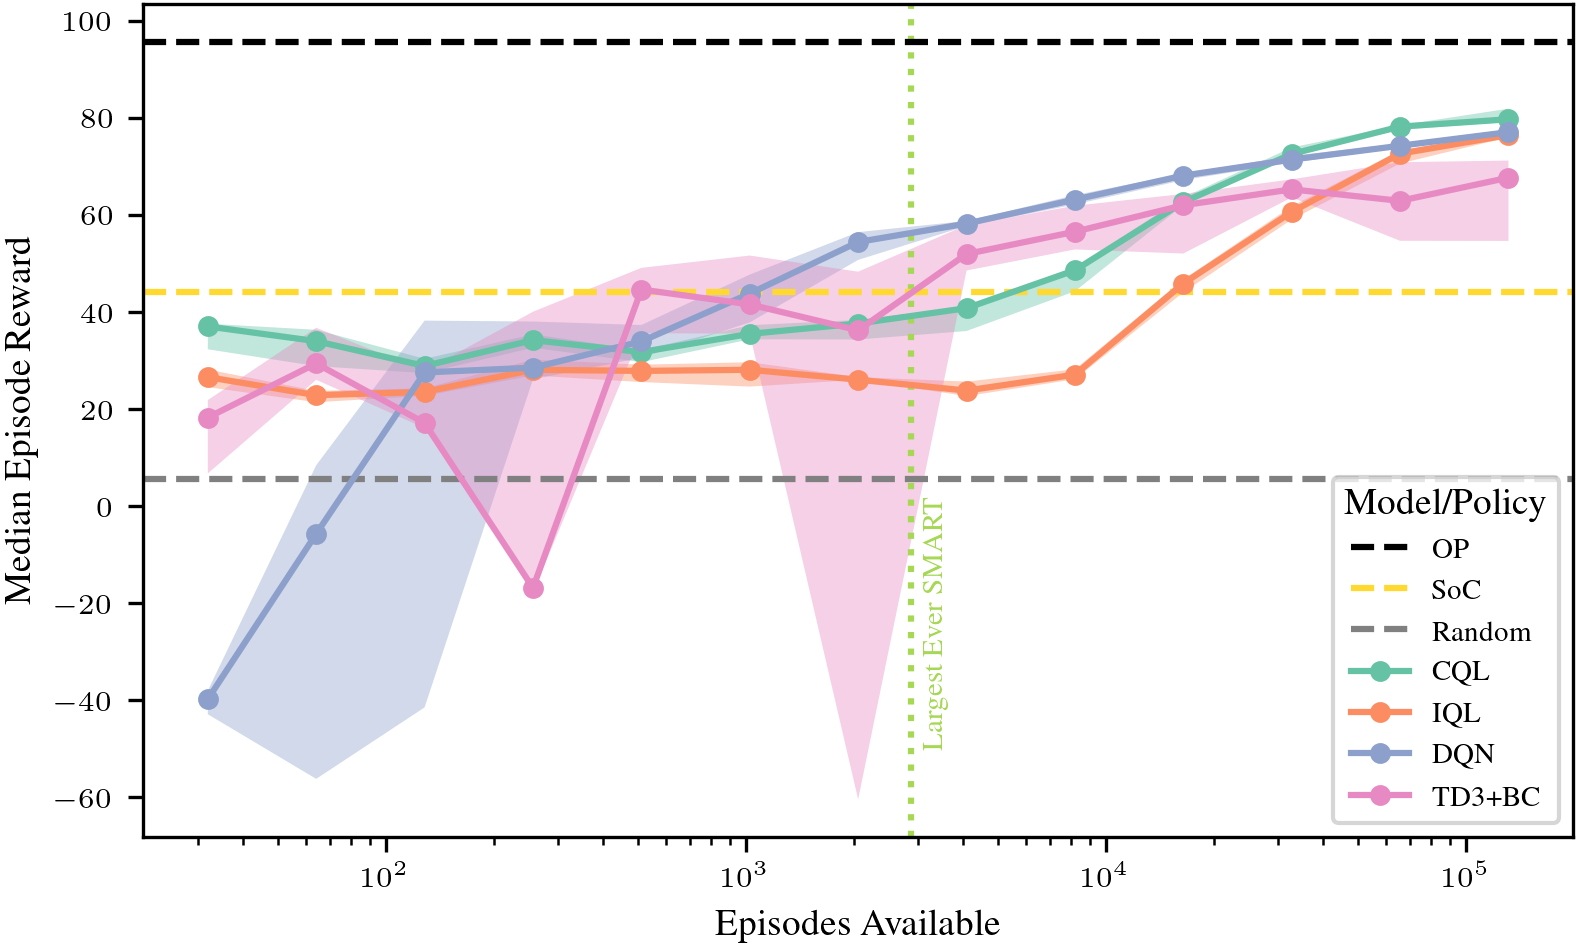

In [96]:
models = ["cql_dqn", "iql", "dqn", "td3_bc"]  # List of models to plot
labels = ["CQL", "IQL", "DQN", "TD3+BC"]  # List of labels for the legend

# Set the Seaborn color palette to the colorblind palette
sns.set_palette("Set2")

# Adding a vertical line at 2876 patients
plt.axvline(x=2876, color="C4", linestyle="dotted")
plt.text(2876+200, 13-11, 'Largest Ever SMART', color='C4', rotation=90, verticalalignment='top', fontsize=7)

# Adding horizontal lines for typical SoC performance
plt.axhline(y=95.7, color="k", linestyle="--", label="OP")
plt.axhline(y=44.2, color="C5", linestyle="--", label="SoC")
plt.axhline(y=5.5, color="gray", linestyle="--", label="Random")

for model in models:
    df = pd.read_csv(os.path.join(results_directory, model + "_restriction.csv"))
    grouped = df.groupby(["episodes_avail"])
    median = grouped["mean_return"].median()
    min = grouped["mean_return"].min()
    max = grouped["mean_return"].max()
    std = grouped["mean_return"].std()

    # Plotting mean
    plt.plot(
        median.index, median, marker="o", label=labels[models.index(model)], markersize=4
    )

    # Adding shaded error (std deviation)
    plt.fill_between(median.index, min, max, alpha=0.4)

# Setting a logarithmic scale for the x-axis
plt.xscale("log")

# Labels and title
plt.xlabel("Episodes Available")
plt.ylabel("Median Episode Reward")

# Making the legend readable and not overlap with the plot
plt.legend(title="Model/Policy", loc="lower right")

# Fine-tuning the appearance
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area

# Saving the figure
plt.savefig("data_restriction_reward.pdf")

# Display the plot
plt.show()

/tmp/ipykernel_522139/3782044345.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area


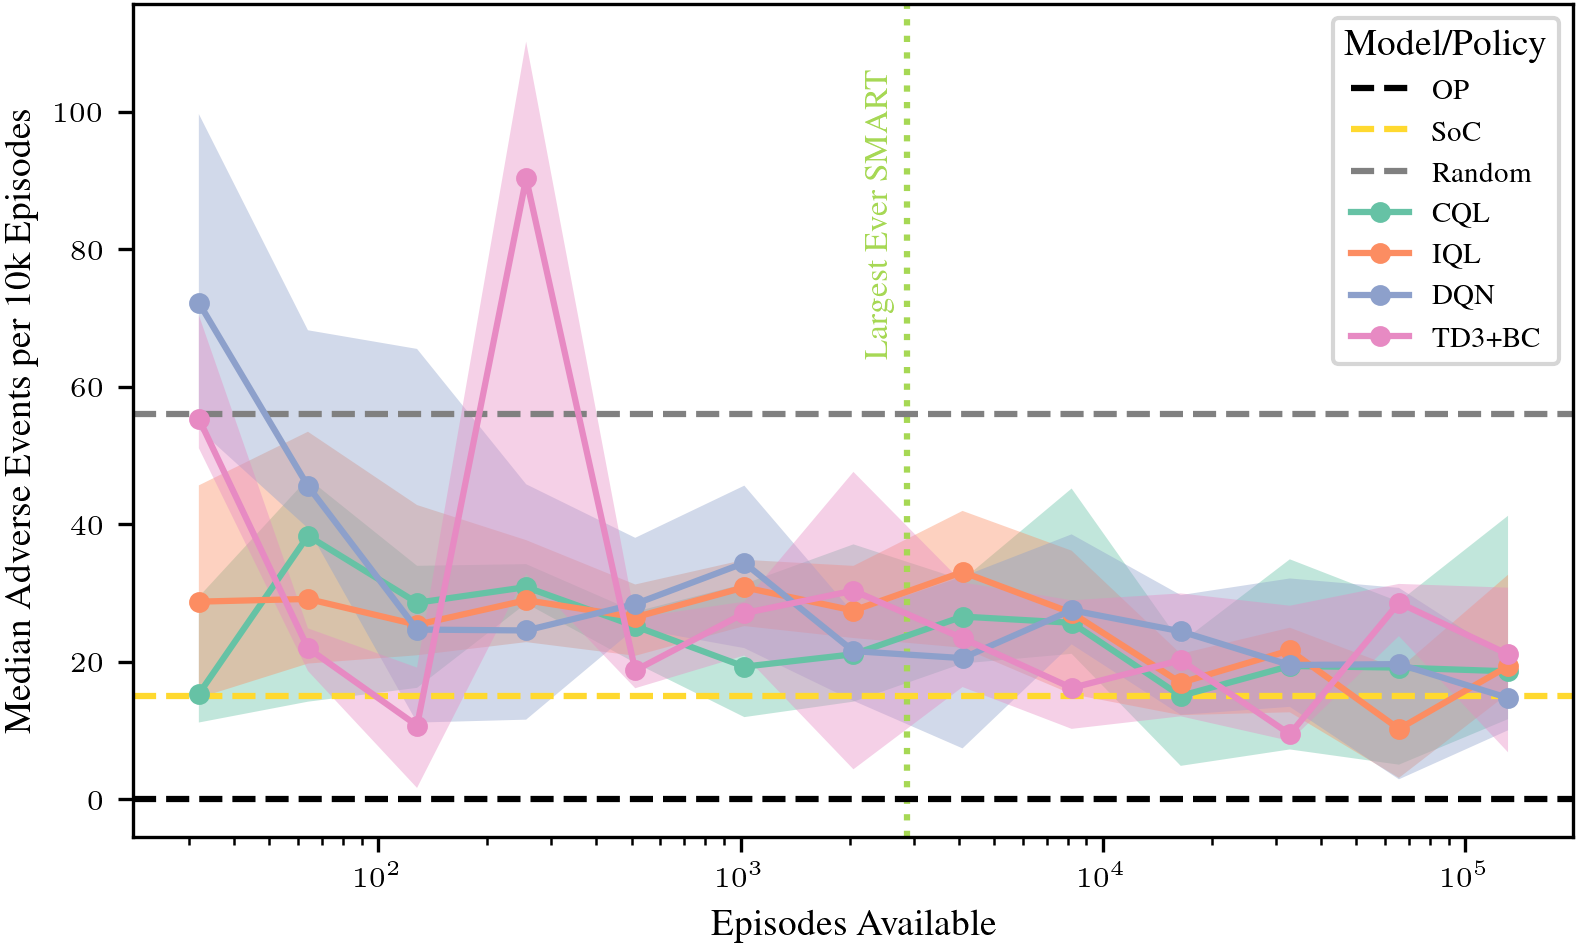

In [100]:
models = ["cql_dqn", "iql", "dqn", "td3_bc"]  # List of models to plot
labels = ["CQL", "IQL", "DQN", "TD3+BC"]  # List of labels for the legend

# Set the Seaborn color palette to the colorblind palette
sns.set_palette("Set2")

# Adding a vertical line at 2876 patients
plt.axvline(x=2876, color="C4", linestyle="dotted")
plt.text(2876 - 675, 64, 'Largest Ever SMART', color='C4', rotation=90, verticalalignment='bottom', fontsize=8)

# Adding horizontal lines for typical SoC performance
plt.axhline(y=0, color="k", linestyle="--", label="OP")
plt.axhline(y=15, color="C5", linestyle="--", label="SoC")
plt.axhline(y=56, color="gray", linestyle="--", label="Random")

for model in models:
    df = pd.read_csv(os.path.join(results_directory, model + "_restriction.csv"))
    grouped = df.groupby(["episodes_avail"])
    median = grouped["mean_adverse_event_rate"].median()*10000
    min = grouped["mean_adverse_event_rate"].min() * 10000
    max = grouped["mean_adverse_event_rate"].max() * 10000
    std = grouped["mean_adverse_event_rate"].std()

    # Plotting mean
    plt.plot(
        median.index, median, marker="o", label=labels[models.index(model)], markersize=4
    )

    # Adding shaded error (std deviation)
    plt.fill_between(median.index, min, max, alpha=0.4)

# Setting a logarithmic scale for the x-axis
plt.xscale("log")

# Labels and title
plt.xlabel("Episodes Available")
plt.ylabel("Median Adverse Events per 10k Episodes")

# Making the legend readable and not overlap with the plot
plt.legend(title="Model/Policy", loc="upper right")

# Fine-tuning the appearance
plt.tight_layout()  # Adjusts subplot params so that the subplot(s) fits into the figure area

# Saving the figure
plt.savefig("data_restriction_aer.pdf")

# Display the plot
plt.show()

In [38]:
from epicare.policies import BasePolicy, _q_star_values

class NewStandardOfCare(BasePolicy):
    """
    A state-agnostic greedy policy that selects the treatment with the highest remission probability.
    """

    def __init__(self, env, alpha=0.5, kappa=0.2):
        self.alpha = alpha  # Learning rate for updating estimates
        self.max_allowable_symptom = 1 - kappa
        super().__init__(env)

    def get_treatment(self, observation):
        # Limit the possible treatments to only those which do not increase any symptom
        # that is currently at or above the policy's adverse event threshold.
        self.max_observation = np.maximum(self.max_observation, observation)
        high_symptoms = self.max_observation > self.max_allowable_symptom
        allowed = [
            i
            for i, treatment in enumerate(self.env.treatments.values())
            if np.all(treatment["treatment_effects"][high_symptoms] <= 0)
        ]

        # Select the allowed treatment with the highest Q-value, falling back on
        # considering all treatments if none are safe.
        return max(allowed or self.Q, key=self.Q.get)

    def update(self, treatment, reward):
        # Update the Q-value for the chosen treatment based on the reward received
        self.Q[treatment] = (1 - self.alpha) * self.Q[treatment] + self.alpha * reward

    def reset(self):
        self.Q = _q_star_values(self.env)
        self.max_observation = 0



100%|██████████| 300000/300000 [07:52<00:00, 634.47it/s] 
/tmp/ipykernel_146679/3759690846.py:117: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


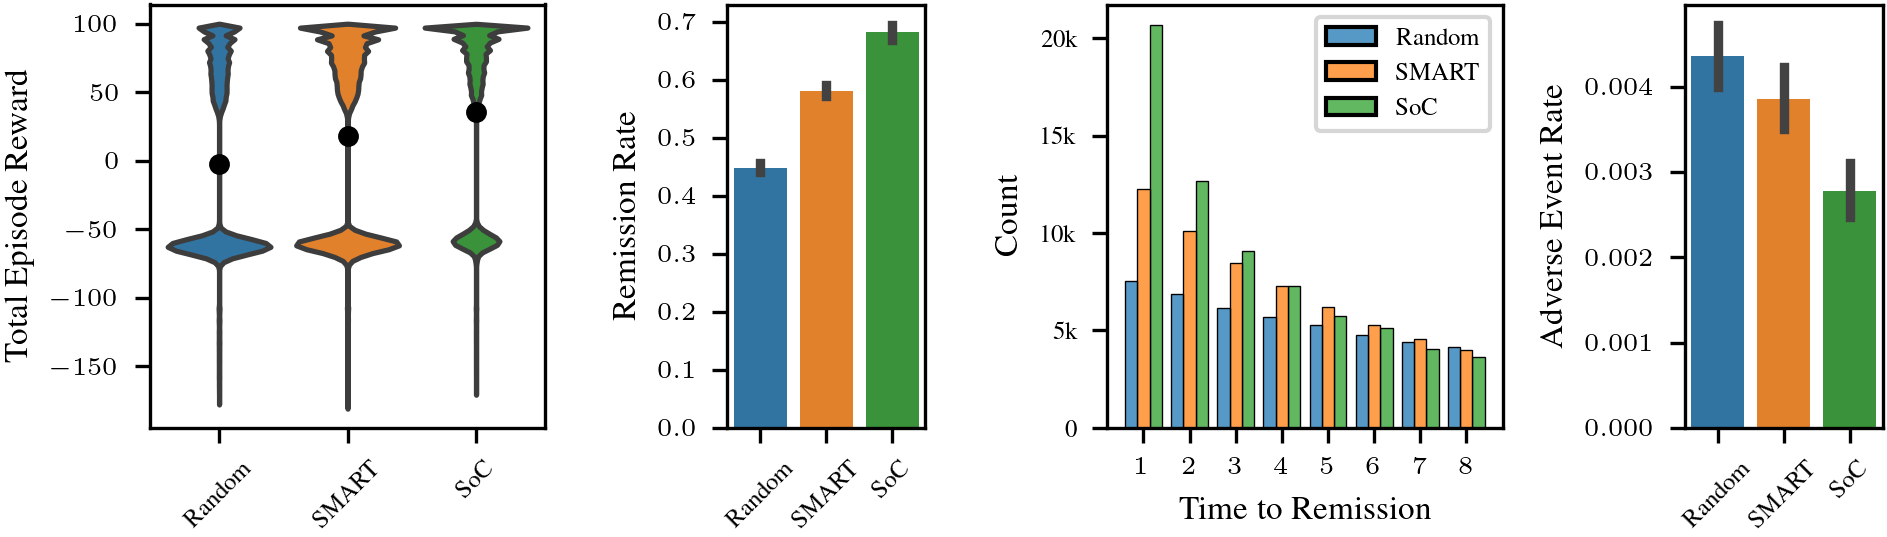

Number of transitions per episode:  1.41391


In [39]:
num_seeds = 100  # Number of random seeds
num_episodes = 1000  # Number of evaluation episodes

# Initialize containers for aggregated data
all_rewards = []
all_remission_rates = []
all_times_to_remission = []
all_adverse_rates = []
num_steps = 0
num_transitions = 0

with tqdm(total=3 * num_episodes * num_seeds) as pbar:
    for seed in range(num_seeds):
        environment = EpiCare(seed=seed)

        # Setting up the policies
        policy_stats = {}
        policies = {
            "Random": Random(environment),
            "SMART": ClinicalTrial(environment),
            "SoC": StandardOfCare(environment),
        }

        # Simulation loop
        policy_stats = {}
        for name, policy in policies.items():
            for episode in range(num_episodes):
                total_reward, time_to_remission, steps, transitions = run_episode(
                    environment, policy, name, policy_stats, verbose=False
                )
                policy_stats[name]["adverse_event"][-1] /= steps
                num_steps += steps
                num_transitions += transitions
                pbar.update()

        # After simulation, calculate averages and remission rates
        for stats in policy_stats.values():
            stats["average_reward"] = np.mean(stats["total_rewards"])
            stats["reward_std"] = np.std(stats["total_rewards"])
            stats["remission_rate"] = np.mean(stats["remission"])
            stats["adverse_rate"] = np.mean(stats["adverse_event"])
            if stats["times_to_remission"]:
                stats["average_time_to_remission"] = np.mean(stats["times_to_remission"])
            else:
                stats["average_time_to_remission"] = None

        policy_names = list(policy_stats.keys())

        # Process and store data for each seed
        df_rewards = pd.DataFrame.from_records(
            [policy_stats[name]["total_rewards"] for name in policy_names]
        ).T
        df_rewards.columns = policy_names
        all_rewards.append(df_rewards)

        remission_rates = [
            np.average(policy_stats[name]["remission_rate"]) for name in policy_names
        ]
        all_remission_rates.append(remission_rates)
        
        adverse_rates = [
            np.average(policy_stats[name]["adverse_rate"]) for name in policy_names
        ]
        all_adverse_rates.append(adverse_rates)

        df_times_to_remission = pd.DataFrame.from_records(
            [policy_stats[name]["times_to_remission"] for name in policy_names]
        ).T
        df_times_to_remission.columns = policy_names
        df_times_to_remission = df_times_to_remission.astype("Int64")
        all_times_to_remission.append(df_times_to_remission)

# Aggregate data across all seeds
agg_rewards = (pd.concat(all_rewards) / 64) * 100
agg_remission_rates = pd.DataFrame(all_remission_rates, columns=policy_names)
agg_times_to_remission = pd.concat(all_times_to_remission)
agg_adverse_rates = pd.DataFrame(all_adverse_rates, columns=policy_names)

# Boxplot setup
fig, axes = plt.subplots(1, 4, figsize=(6.5, 2.0), width_ratios=[2,1,2,1])

# Aggregate plots
# Plot 1: Total Reward
sns.violinplot(data=agg_rewards, ax=axes[0], bw_adjust=0.1, inner=None)
# Mark the mean for each policy
for i, name in enumerate(policy_names):
    axes[0].plot(i, agg_rewards[name].mean(), "o", color="black", markersize=4)
axes[0].set_ylabel("Total Episode Reward")

# Plot 2: Remission Rate
sns.barplot(data=agg_remission_rates, ax=axes[1])
axes[1].set_ylabel("Remission Rate")

# Plot 3: Time to Remission
sns.histplot(
    data=agg_times_to_remission, ax=axes[2], multiple="dodge", discrete=True, shrink=0.8
)
axes[2].set_ylabel("Count")
axes[2].yaxis
axes[2].set_xlabel("Time to Remission")
axes[2].set_xticks(range(1, environment.max_visits + 1))
axes[2].axes.yaxis.set_major_formatter(lambda value, text: str(int(value/1000))+"k" if value > 0 else "0")

# Plot 4: Adverse Event Rate
sns.barplot(data=agg_adverse_rates, ax=axes[3])
axes[3].set_ylabel("Adverse Event Rate")

# Fine-tuning the aesthetics for publication quality
for ax in axes:
    if ax != axes[2]:
        ax.tick_params(axis="x", labelrotation=45)
    ax.tick_params(axis="both", which="major")
    if ax == axes[1]:
        ax.set_ylim(bottom=0)

# Adjusting the layout to prevent overlap
plt.tight_layout()

plt.savefig("compare_policies.pdf")

# Display plots
plt.show()

print(
    "Number of transitions per episode: ",
    num_transitions / (num_episodes * num_seeds * 3),
)

/tmp/ipykernel_146679/1624777400.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


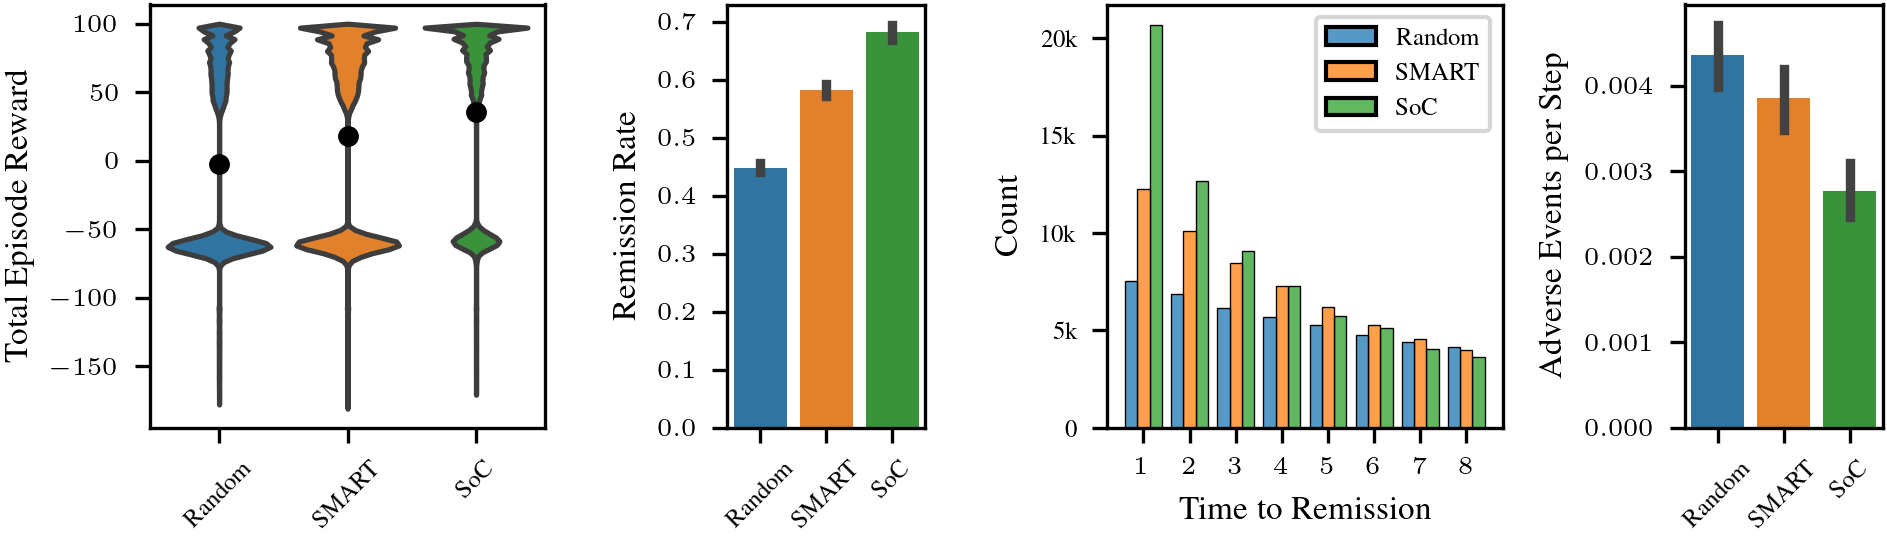

Number of transitions per episode:  1.41391


In [40]:

# Boxplot setup
fig, axes = plt.subplots(1, 4, figsize=(6.5, 2.0), width_ratios=[2,1,2,1])

# Aggregate plots
# Plot 1: Total Reward
sns.violinplot(data=agg_rewards, ax=axes[0], bw_adjust=0.1, inner=None)
# Mark the mean for each policy
for i, name in enumerate(policy_names):
    axes[0].plot(i, agg_rewards[name].mean(), "o", color="black", markersize=4)
axes[0].set_ylabel("Total Episode Reward")

# Plot 2: Remission Rate
sns.barplot(data=agg_remission_rates, ax=axes[1])
axes[1].set_ylabel("Remission Rate")

# Plot 3: Time to Remission
sns.histplot(
    data=agg_times_to_remission, ax=axes[2], multiple="dodge", discrete=True, shrink=0.8
)
axes[2].set_ylabel("Count")
axes[2].yaxis
axes[2].set_xlabel("Time to Remission")
axes[2].set_xticks(range(1, environment.max_visits + 1))
axes[2].axes.yaxis.set_major_formatter(lambda value, text: str(int(value/1000))+"k" if value > 0 else "0")

# Plot 4: Adverse Event Rate
sns.barplot(data=agg_adverse_rates, ax=axes[3])
axes[3].set_ylabel("Adverse Events per Step")

# Fine-tuning the aesthetics for publication quality
for ax in axes:
    if ax != axes[2]:
        ax.tick_params(axis="x", labelrotation=45)
    ax.tick_params(axis="both", which="major")
    if ax == axes[1]:
        ax.set_ylim(bottom=0)

# Adjusting the layout to prevent overlap
plt.tight_layout()

plt.savefig("compare_policies.pdf")

# Display plots
plt.show()

print(
    "Number of transitions per episode: ",
    num_transitions / (num_episodes * num_seeds * 3),
)

100%|██████████| 1100000/1100000 [27:07<00:00, 675.70it/s] 
/tmp/ipykernel_146679/2050064621.py:121: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


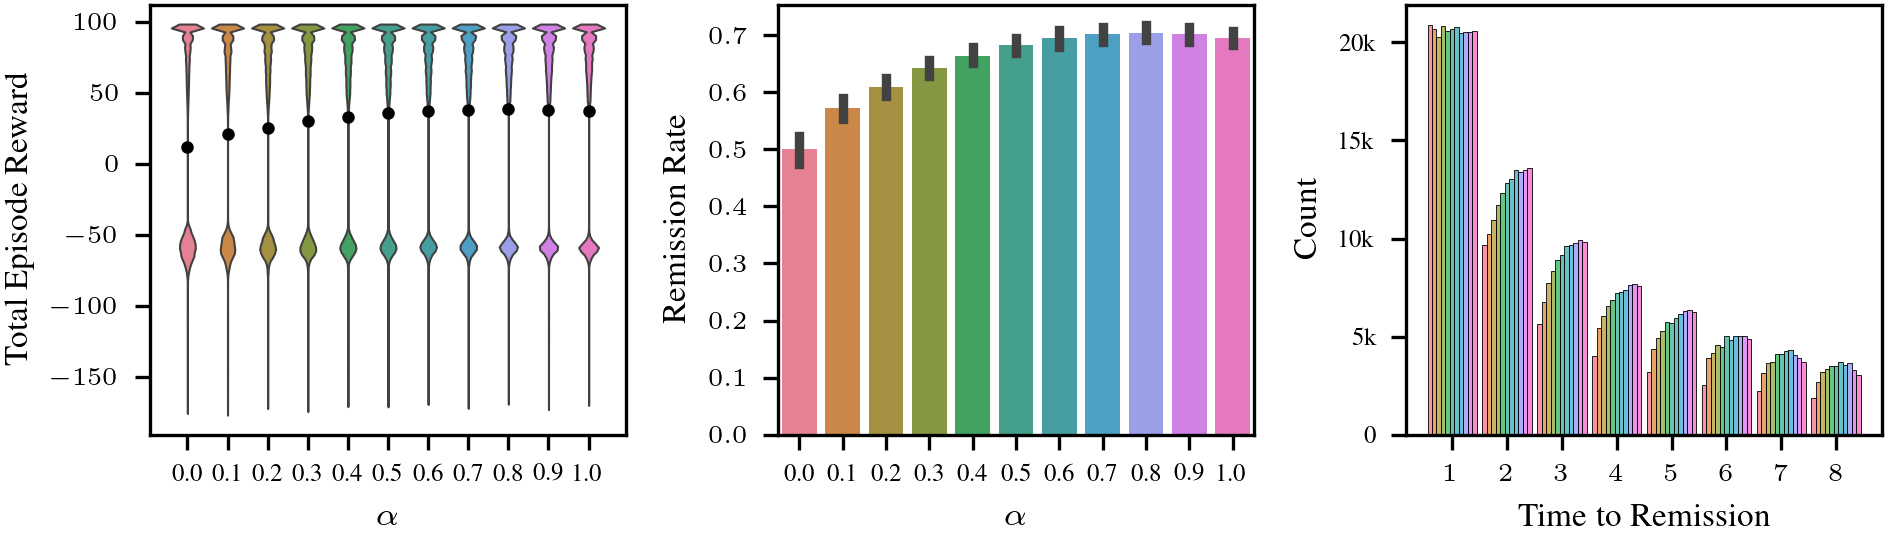

In [41]:
num_seeds = 100  # Number of random seeds
num_episodes = 1000  # Number of separate evaluation episodes

# Initialize containers for aggregated data
all_rewards = []
all_remission_rates = []
all_times_to_remission = []
all_adverse_rates = []
num_steps = 0
num_transitions = 0

with tqdm(total=11*num_episodes*num_seeds) as pbar:
    for seed in range(num_seeds):
        environment = EpiCare(seed=seed)

        # Setting up the policies
        policy_stats = {}
        # SoC with all alphas between 0 and 1, in increments of 0.1
        policies = {
            f"{alpha:.1f}": StandardOfCare(environment, alpha=alpha)
            for alpha in [i * 0.1 for i in range(11)]
        }

        # Simulation loop
        policy_stats = {}
        for name, policy in policies.items():
            for episode in range(num_episodes):
                total_reward, time_to_remission, steps, transitions = run_episode(
                    environment, policy, name, policy_stats, verbose=False
                )
                num_steps += steps
                num_transitions += transitions
                pbar.update()

        # After simulation, calculate averages and remission rates
        for stats in policy_stats.values():
            stats["average_reward"] = np.mean(stats["total_rewards"])
            stats["reward_std"] = np.std(stats["total_rewards"])
            stats["remission_rate"] = np.mean(stats["remission"])
            stats["adverse_rate"] = np.mean(stats["adverse_event"])
            if stats["times_to_remission"]:
                stats["average_time_to_remission"] = np.mean(stats["times_to_remission"])
            else:
                stats["average_time_to_remission"] = None

        policy_names = list(policy_stats.keys())

        # Process and store data for each seed
        df_rewards = pd.DataFrame.from_records(
            [policy_stats[name]["total_rewards"] for name in policy_names]
        ).T
        df_rewards.columns = policy_names
        all_rewards.append(df_rewards)

        remission_rates = [
            np.average(policy_stats[name]["remission_rate"]) for name in policy_names
        ]
        all_remission_rates.append(remission_rates)
        
        adverse_rates = [
            np.average(policy_stats[name]["adverse_rate"]) for name in policy_names
        ]
        all_adverse_rates.append(adverse_rates)

        df_times_to_remission = pd.DataFrame.from_records(
            [policy_stats[name]["times_to_remission"] for name in policy_names]
        ).T
        df_times_to_remission.columns = policy_names
        df_times_to_remission = df_times_to_remission.astype("Int64")
        all_times_to_remission.append(df_times_to_remission)

# Aggregate data across all seeds
agg_rewards = (pd.concat(all_rewards) / 64) * 100
agg_remission_rates = pd.DataFrame(all_remission_rates, columns=policy_names)
agg_times_to_remission = pd.concat(all_times_to_remission)
agg_adverse_rates = pd.DataFrame(all_adverse_rates, columns=policy_names)

# Generate a list of alpha values as strings for the x-axis labels
fig, axes = plt.subplots(1, 3, figsize=(6.5, 2.0))

# Plot 1: Total Reward
sns.violinplot(
    data=agg_rewards, ax=axes[0], bw_adjust=0.1, cut=0.0, inner=None, linewidth=0.5
)
for i, alpha in enumerate(policies):
    axes[0].plot(i, agg_rewards[alpha].mean(), "o", color="black", markersize=2)
axes[0].set_ylabel("Total Episode Reward")
axes[0].set_xlabel("$\\alpha$")

# Plot 2: Remission Rate
sns.barplot(data=agg_remission_rates, ax=axes[1])
axes[1].set_ylabel("Remission Rate")
axes[1].set_xlabel("$\\alpha$")

# Plot 3: Time to Remission
sns.histplot(
    data=agg_times_to_remission.melt(var_name="Policy", value_name="Time_to_Remission"),
    x="Time_to_Remission",
    hue="Policy",
    ax=axes[2],
    multiple="dodge",
    discrete=True,
    shrink=0.9,
    linewidth=0.2,
)
axes[2].set_ylabel("Count")
axes[2].set_xlabel("Time to Remission")
axes[2].set_xticks(range(1, environment.max_visits + 1))
# remove legend completely
axes[2].get_legend().remove()
axes[2].axes.yaxis.set_major_formatter(lambda value, text: str(int(value/1000))+"k" if value > 0 else "0")

# Fine-tuning the aesthetics for publication quality
for ax in axes:
    ax.tick_params(axis="x", labelrotation=0)
    ax.tick_params(axis="both", which="major")
    if ax == axes[1]:
        ax.set_ylim(bottom=0)

# Adjusting the layout to prevent overlap
plt.tight_layout()

plt.savefig("SoC_alpha.pdf")

# Display plots
plt.show()

  0%|          | 0/6000000 [00:00<?, ?it/s]

100%|██████████| 6000000/6000000 [2:18:07<00:00, 724.02it/s]  
/tmp/ipykernel_146679/4040674134.py:125: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


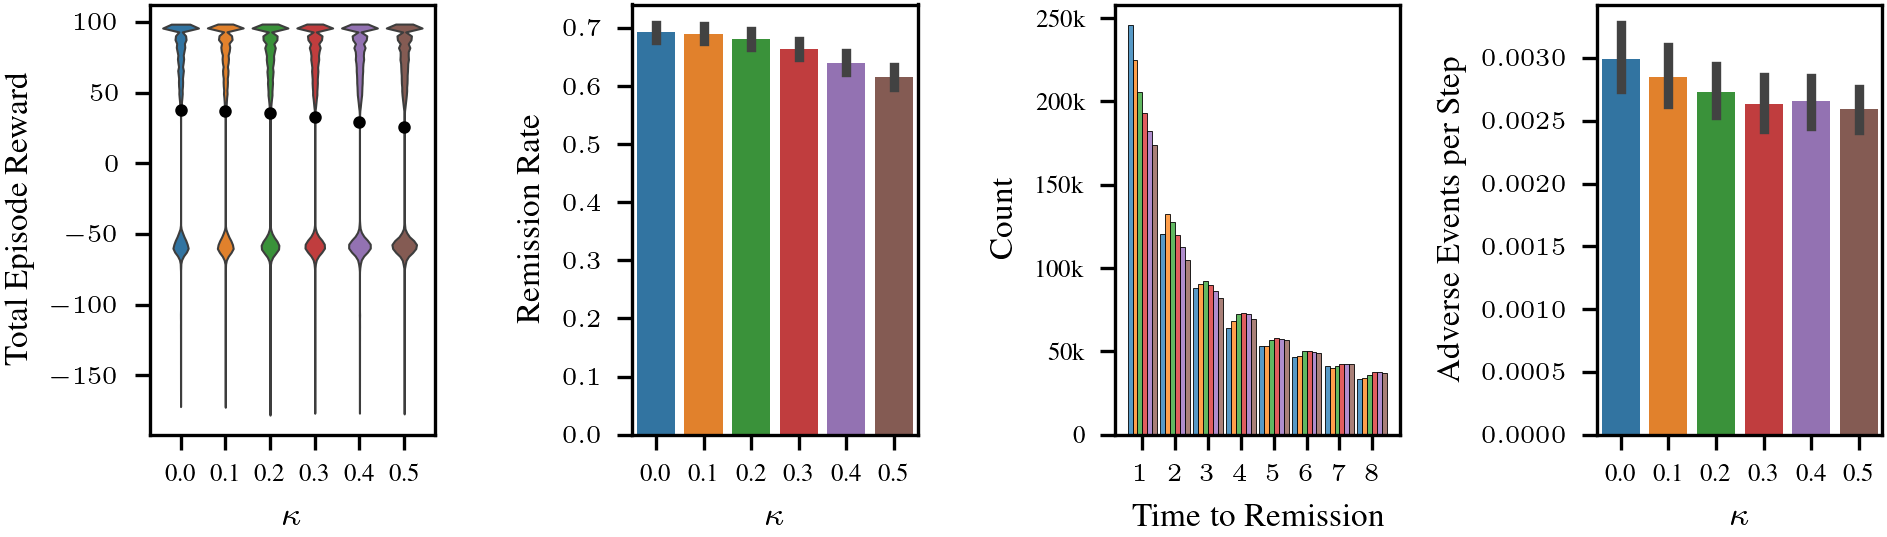

In [42]:
num_seeds = 100  # Number of random seeds
num_episodes = 10000  # Number of separate evaluation episodes

# Initialize containers for aggregated data
all_rewards = []
all_remission_rates = []
all_times_to_remission = []
all_adverse_rates = []
num_steps = 0
num_transitions = 0

with tqdm(total=6*num_episodes*num_seeds) as pbar:
    for seed in range(num_seeds):
        environment = EpiCare(seed=seed)

        # Setting up the policies
        policy_stats = {}
        # SoC with all kappas between 0 and 0.5, in increments of 0.1
        policies = {
            f"{kappa:.1f}": StandardOfCare(environment, kappa=kappa)
            for kappa in [i * 0.1 for i in range(6)]
        }

        # Simulation loop
        policy_stats = {}
        for name, policy in policies.items():
            for episode in range(num_episodes):
                total_reward, time_to_remission, steps, transitions = run_episode(
                    environment, policy, name, policy_stats, verbose=False
                )
                policy_stats[name]["adverse_event"][-1] /= steps
                num_steps += steps
                num_transitions += transitions
                pbar.update()

        # After simulation, calculate averages and remission rates
        for stats in policy_stats.values():
            stats["average_reward"] = np.mean(stats["total_rewards"])
            stats["reward_std"] = np.std(stats["total_rewards"])
            stats["remission_rate"] = np.mean(stats["remission"])
            stats["adverse_rate"] = np.mean(stats["adverse_event"])
            if stats["times_to_remission"]:
                stats["average_time_to_remission"] = np.mean(stats["times_to_remission"])
            else:
                stats["average_time_to_remission"] = None

        policy_names = list(policy_stats.keys())

        # Process and store data for each seed
        df_rewards = pd.DataFrame.from_records(
            [policy_stats[name]["total_rewards"] for name in policy_names]
        ).T
        df_rewards.columns = policy_names
        all_rewards.append(df_rewards)

        remission_rates = [
            np.average(policy_stats[name]["remission_rate"]) for name in policy_names
        ]
        all_remission_rates.append(remission_rates)
        
        adverse_rates = [
            np.average(policy_stats[name]["adverse_rate"]) for name in policy_names
        ]
        all_adverse_rates.append(adverse_rates)

        df_times_to_remission = pd.DataFrame.from_records(
            [policy_stats[name]["times_to_remission"] for name in policy_names]
        ).T
        df_times_to_remission.columns = policy_names
        df_times_to_remission = df_times_to_remission.astype("Int64")
        all_times_to_remission.append(df_times_to_remission)

# Aggregate data across all seeds, then plot
agg_rewards = (pd.concat(all_rewards) / 64) * 100
agg_remission_rates = pd.DataFrame(all_remission_rates, columns=policy_names)
agg_times_to_remission = pd.concat(all_times_to_remission)
agg_adverse_rates = pd.DataFrame(all_adverse_rates, columns=policy_names)
fig, axes = plt.subplots(1, 4, figsize=(6.5, 2.0))

# Plot 1: Total Reward
sns.violinplot(
    data=agg_rewards, ax=axes[0], bw_adjust=0.1, cut=0.0, inner=None, linewidth=0.5
)
for i, kappa in enumerate(policies):
    axes[0].plot(i, agg_rewards[kappa].mean(), "o", color="black", markersize=2)
axes[0].set_ylabel("Total Episode Reward")
axes[0].set_xlabel("$\\kappa$")

# Plot 2: Remission Rate
sns.barplot(data=agg_remission_rates, ax=axes[1])
axes[1].set_ylabel("Remission Rate")
axes[1].set_xlabel("$\\kappa$")

# Plot 3: Time to Remission
sns.histplot(
    data=agg_times_to_remission.melt(var_name="Policy", value_name="Time_to_Remission"),
    x="Time_to_Remission",
    hue="Policy",
    ax=axes[2],
    multiple="dodge",
    discrete=True,
    shrink=0.9,
    linewidth=0.2,
)
axes[2].set_ylabel("Count")
axes[2].set_xlabel("Time to Remission")
axes[2].set_xticks(range(1, environment.max_visits + 1))
# remove legend completely
axes[2].get_legend().remove()
axes[2].axes.yaxis.set_major_formatter(lambda value, text: str(int(value/1000))+"k" if value > 0 else "0")

# Plot 4: Adverse Event Rate
sns.barplot(data=agg_adverse_rates, ax=axes[3])
axes[3].set_ylabel("Adverse Events per Step")
axes[3].set_xlabel("$\\kappa$")

# Fine-tuning the aesthetics for publication quality
for ax in axes:
    ax.tick_params(axis="x", labelrotation=0)
    ax.tick_params(axis="both", which="major")
    if ax == axes[1]:
        ax.set_ylim(bottom=0)

# Adjusting the layout to prevent overlap
plt.tight_layout()

plt.savefig("SoC_kappa.pdf")

# Display plots
plt.show()

In [18]:
model_data_sorted

,Model,MeanLogProb,StdDev,AverageRMSE
2,bc,6.812027,0.116723,3.366382
1,awac,6.947396,0.132846,5.334611
4,iql,12.038860,0.961693,35.254002
0,edac,106.328589,94.134215,40.811983
3,td3_bc,170.902545,24.870233,34.857281
6,cql-dqn,244.771059,7.234664,36.134745
5,dqn,245.121105,6.991666,36.963866


/tmp/ipykernel_522139/2338223546.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([model_labes_dict[model] for model in model_data_sorted["Model"]])
/tmp/ipykernel_522139/2338223546.py:93: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


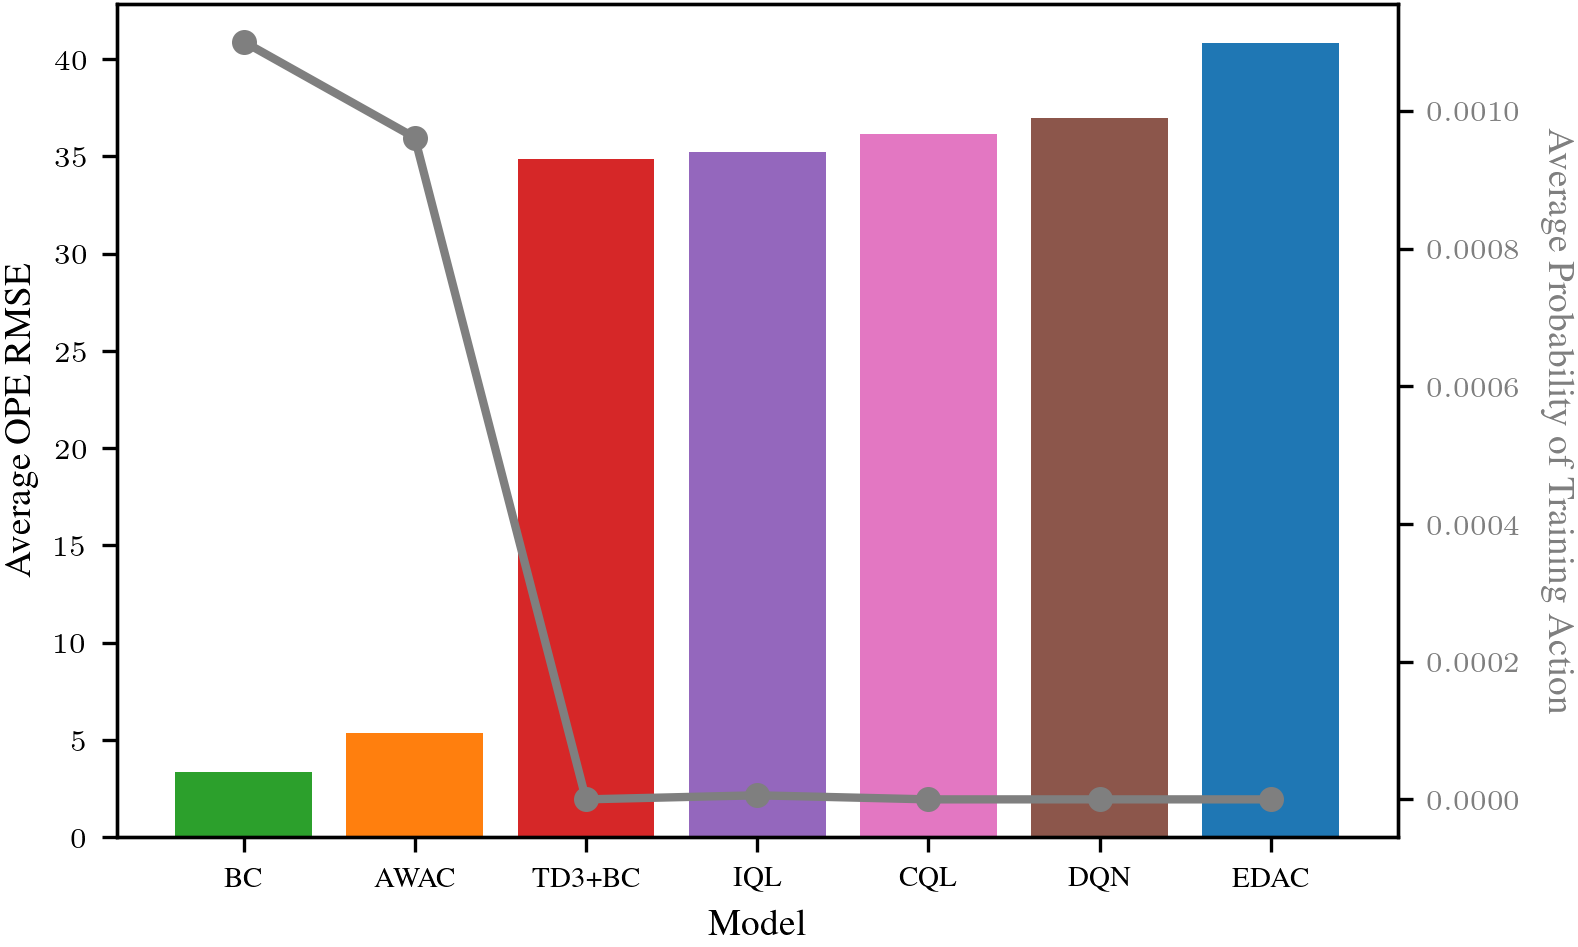

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Define OPE methods and models
models = ["edac", "awac", "bc", "td3_bc", "iql", "dqn", "cql-dqn"]
model_labels = ["EDAC", "AWAC", "BC", "TD3+BC", "IQL", "DQN", "CQL"]
ope_methods = ["is", "wis", "pdis", "wpdis"]
colors = ["C" + str(i) for i in range(len(models))]
color_dict = dict(zip(models, colors))
model_labes_dict = dict(zip(models, model_labels))

# Initialize lists to store mean log_probs, their standard deviations, and average RMSE for each model
mean_log_probs = []
std_devs = []
average_rmse_values = []

# Process data for each model to get log_probs and calculate RMSE
for model in models:
    df = pd.read_csv(os.path.join(results_directory, model + "_results.csv"))
    # Filter rows for checkpoint_32.pt
    if "checkpoint" in df.columns:
        df_filtered = df[df["checkpoint"] == "checkpoint_31.pt"]
        abs_log_probs = df_filtered["mean_meanlogprob_estimate"].abs()
        mean_log_prob = abs_log_probs.mean()
        std_dev = abs_log_probs.std()
    else:
        mean_log_prob = std_dev = np.nan

    mean_log_probs.append(mean_log_prob)
    std_devs.append(std_dev)

    # Calculate RMSE for each model across all OPE methods
    rmse_values = []
    for method in ope_methods:
        online_means = df["mean_return"]
        ope_means = df[f"mean_{method}_estimate"]
        rmse = np.sqrt(
            np.mean(
                (np.clip(ope_means, -100, 100) - np.clip(online_means, -100, 100)) ** 2
            )
        )
        rmse_values.append(rmse)
    average_rmse = np.mean(rmse_values)
    average_rmse_values.append(average_rmse)

# Combine models, their mean log_probs, std_devs, and average RMSE into a DataFrame for sorting
model_data = pd.DataFrame(
    {
        "Model": models,
        "MeanLogProb": mean_log_probs,
        "StdDev": std_devs,
        "AverageRMSE": average_rmse_values,
    }
)

# Sort by AverageRMSE from smallest to largest
model_data_sorted = model_data.sort_values(by="AverageRMSE")

# Create a bar graph for Average RMSE
fig, ax1 = plt.subplots()
ax1.bar(
    model_data_sorted["Model"],
    model_data_sorted["AverageRMSE"],
    color=[color_dict[model] for model in model_data_sorted["Model"]],
    capsize=5,
)
ax1.set_xlabel("Model")
ax1.set_ylabel("Average OPE RMSE", color="k")
ax1.tick_params(axis="y", labelcolor="k")
ax1.set_xticklabels([model_labes_dict[model] for model in model_data_sorted["Model"]])

# Add a secondary y-axis for Mean Abs Log Probability as a line graph
ax2 = ax1.twinx()
ax2.plot(
    model_data_sorted["Model"],
    np.e ** -model_data_sorted["MeanLogProb"],
    color="C" + str(len(model)),
    marker="o",
    linestyle="-",
    linewidth=2,
    markersize=5,
)
ax2.set_ylabel(
    "Average Probability of Training Action",
    color="C" + str(len(model)),
    rotation=-90,
    labelpad=13,
)
ax2.tick_params(axis="y", labelcolor="C" + str(len(model)))

plt.tight_layout()
plt.savefig("avg_probs_and_rmse.pdf")  # Save as high-resolution image
plt.show()

/tmp/ipykernel_522139/3978975497.py:59: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


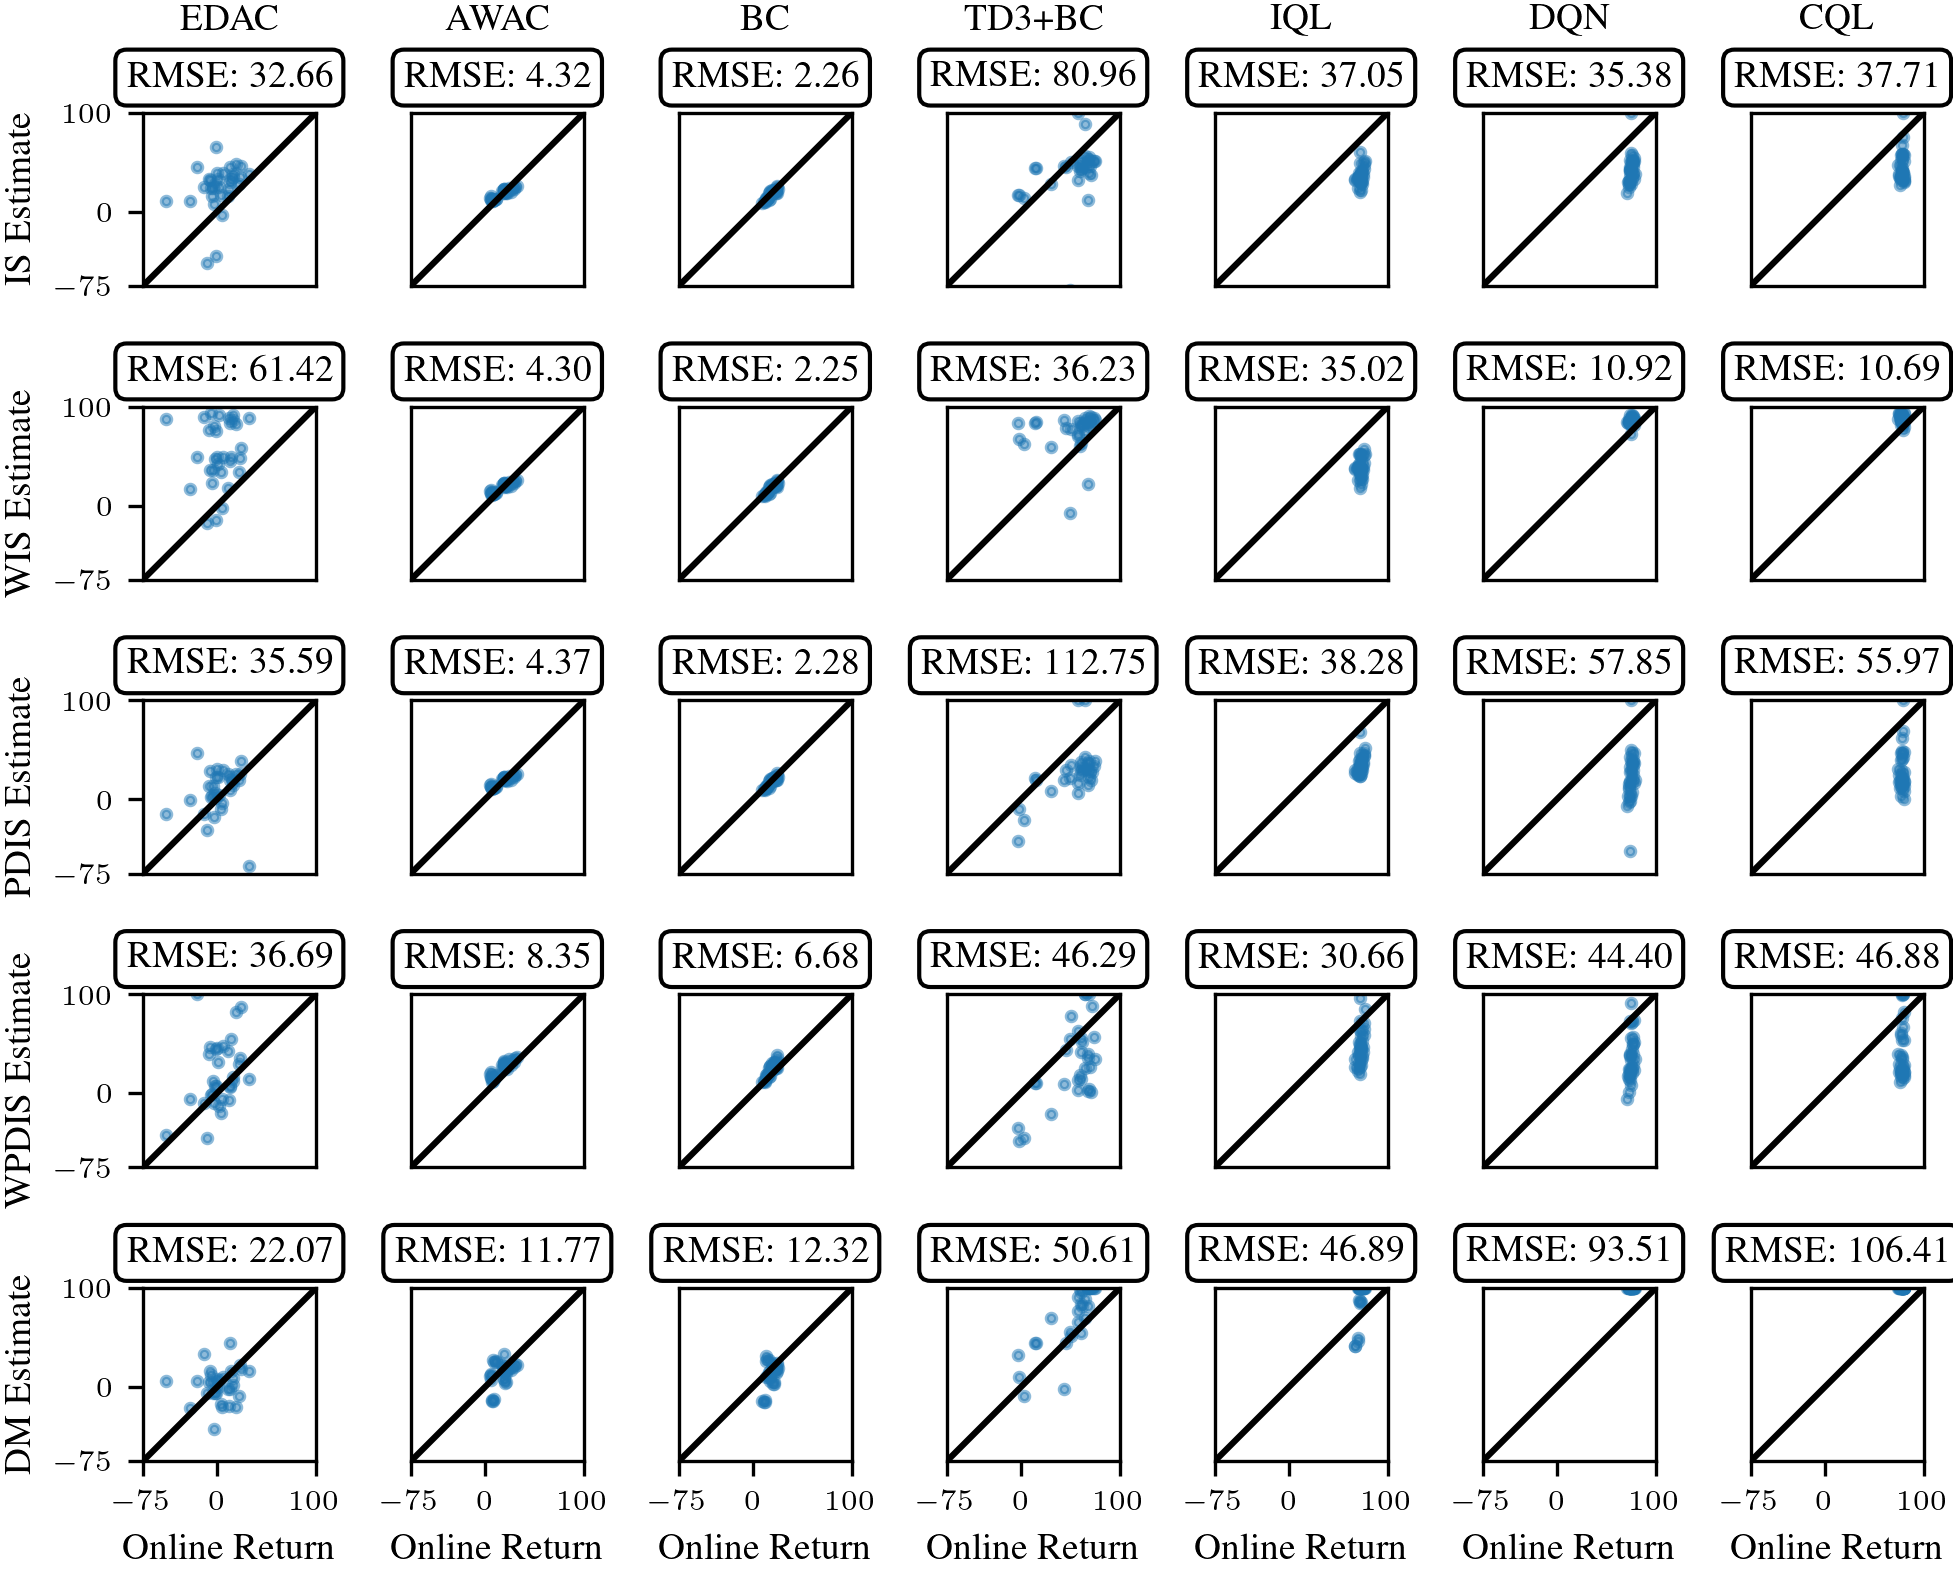

Average RMSE for each model: {'edac': 37.68627571780934, 'awac': 6.622342971770825, 'bc': 5.157379583441985, 'td3_bc': 65.36727313516157, 'iql': 37.58020145748683, 'dqn': 48.41089150750771, 'cql-dqn': 51.53294728026508}


In [ ]:
ope_methods = ["is", "wis", "pdis", "wpdis", "direct"]
ope_labels = ["IS", "WIS", "PDIS", "WPDIS", "DM"]
models = ["edac","awac", "bc", "td3_bc", "iql", "dqn", "cql-dqn"]
model_labels = ["EDAC", "AWAC", "BC", "TD3+BC", "IQL", "DQN", "CQL"]

# Create a figure with subplots
fig, axes = plt.subplots(
    ncols=len(models), nrows=len(ope_methods), figsize=(6.75, 5.5)
)  # Adjust size as needed

# Initialize a dictionary to store RMSE values for each model
model_rmse = {model: [] for model in models}

# Process data for each model and each OPE method
for col, model in enumerate(models):
    for row, method in enumerate(ope_methods):
        df = pd.read_csv(os.path.join(results_directory, model + "_results.csv"))
        online_means = df["mean_return"]
        ope_means = df[f"mean_{method}_estimate"]

        # Clip the values to be between -100 and 100
        online_means_clipped = np.clip(online_means, -100, 100)
        ope_means_clipped = np.clip(ope_means, -100, 100)

        # Calculate RMSE and store it
        rmse = np.sqrt(np.mean((online_means - ope_means) ** 2))
        model_rmse[model].append(rmse)

        # Plot scatter for each method and model
        axes[row, col].scatter(online_means_clipped, ope_means_clipped, s=5, alpha=0.5)
        axes[row, col].set_aspect("equal", adjustable="box")
        axes[row, col].set_xlim([-75, 100])
        axes[row, col].set_ylim([-75, 100])
        axes[row, col].plot([-75, 100], [-75, 100], color="black")  # y=x line
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

        # Add RMSE as an insert, centered below the scatter plot
        axes[row, col].text(
            0.5,
            1.3,
            f"RMSE: {rmse:0.2f}",
            transform=axes[row, col].transAxes,
            horizontalalignment="center",
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.3", alpha=1.0, facecolor="white"),
        )

for row in range(len(ope_methods)):
    axes[row, 0].set_ylabel(ope_labels[row] + " Estimate")
    axes[row, 0].set_yticks([-75, 0, 100])

for col in range(len(models)):
    axes[0, col].set_title(model_labels[col].upper(), pad=20)
    axes[-1, col].set_xlabel("Online Return")
    axes[-1, col].xaxis.tick_bottom()
    axes[-1, col].set_xticks([-75, 0, 100])

plt.tight_layout()
plt.savefig("ope_scatter.pdf")  # Save as high-resolution image
plt.show()

# Calculate and print average RMSE for each model
average_rmse = {model: np.mean(rmses) for model, rmses in model_rmse.items()}
print("Average RMSE for each model:", average_rmse)

/tmp/ipykernel_522139/1929174831.py:38: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


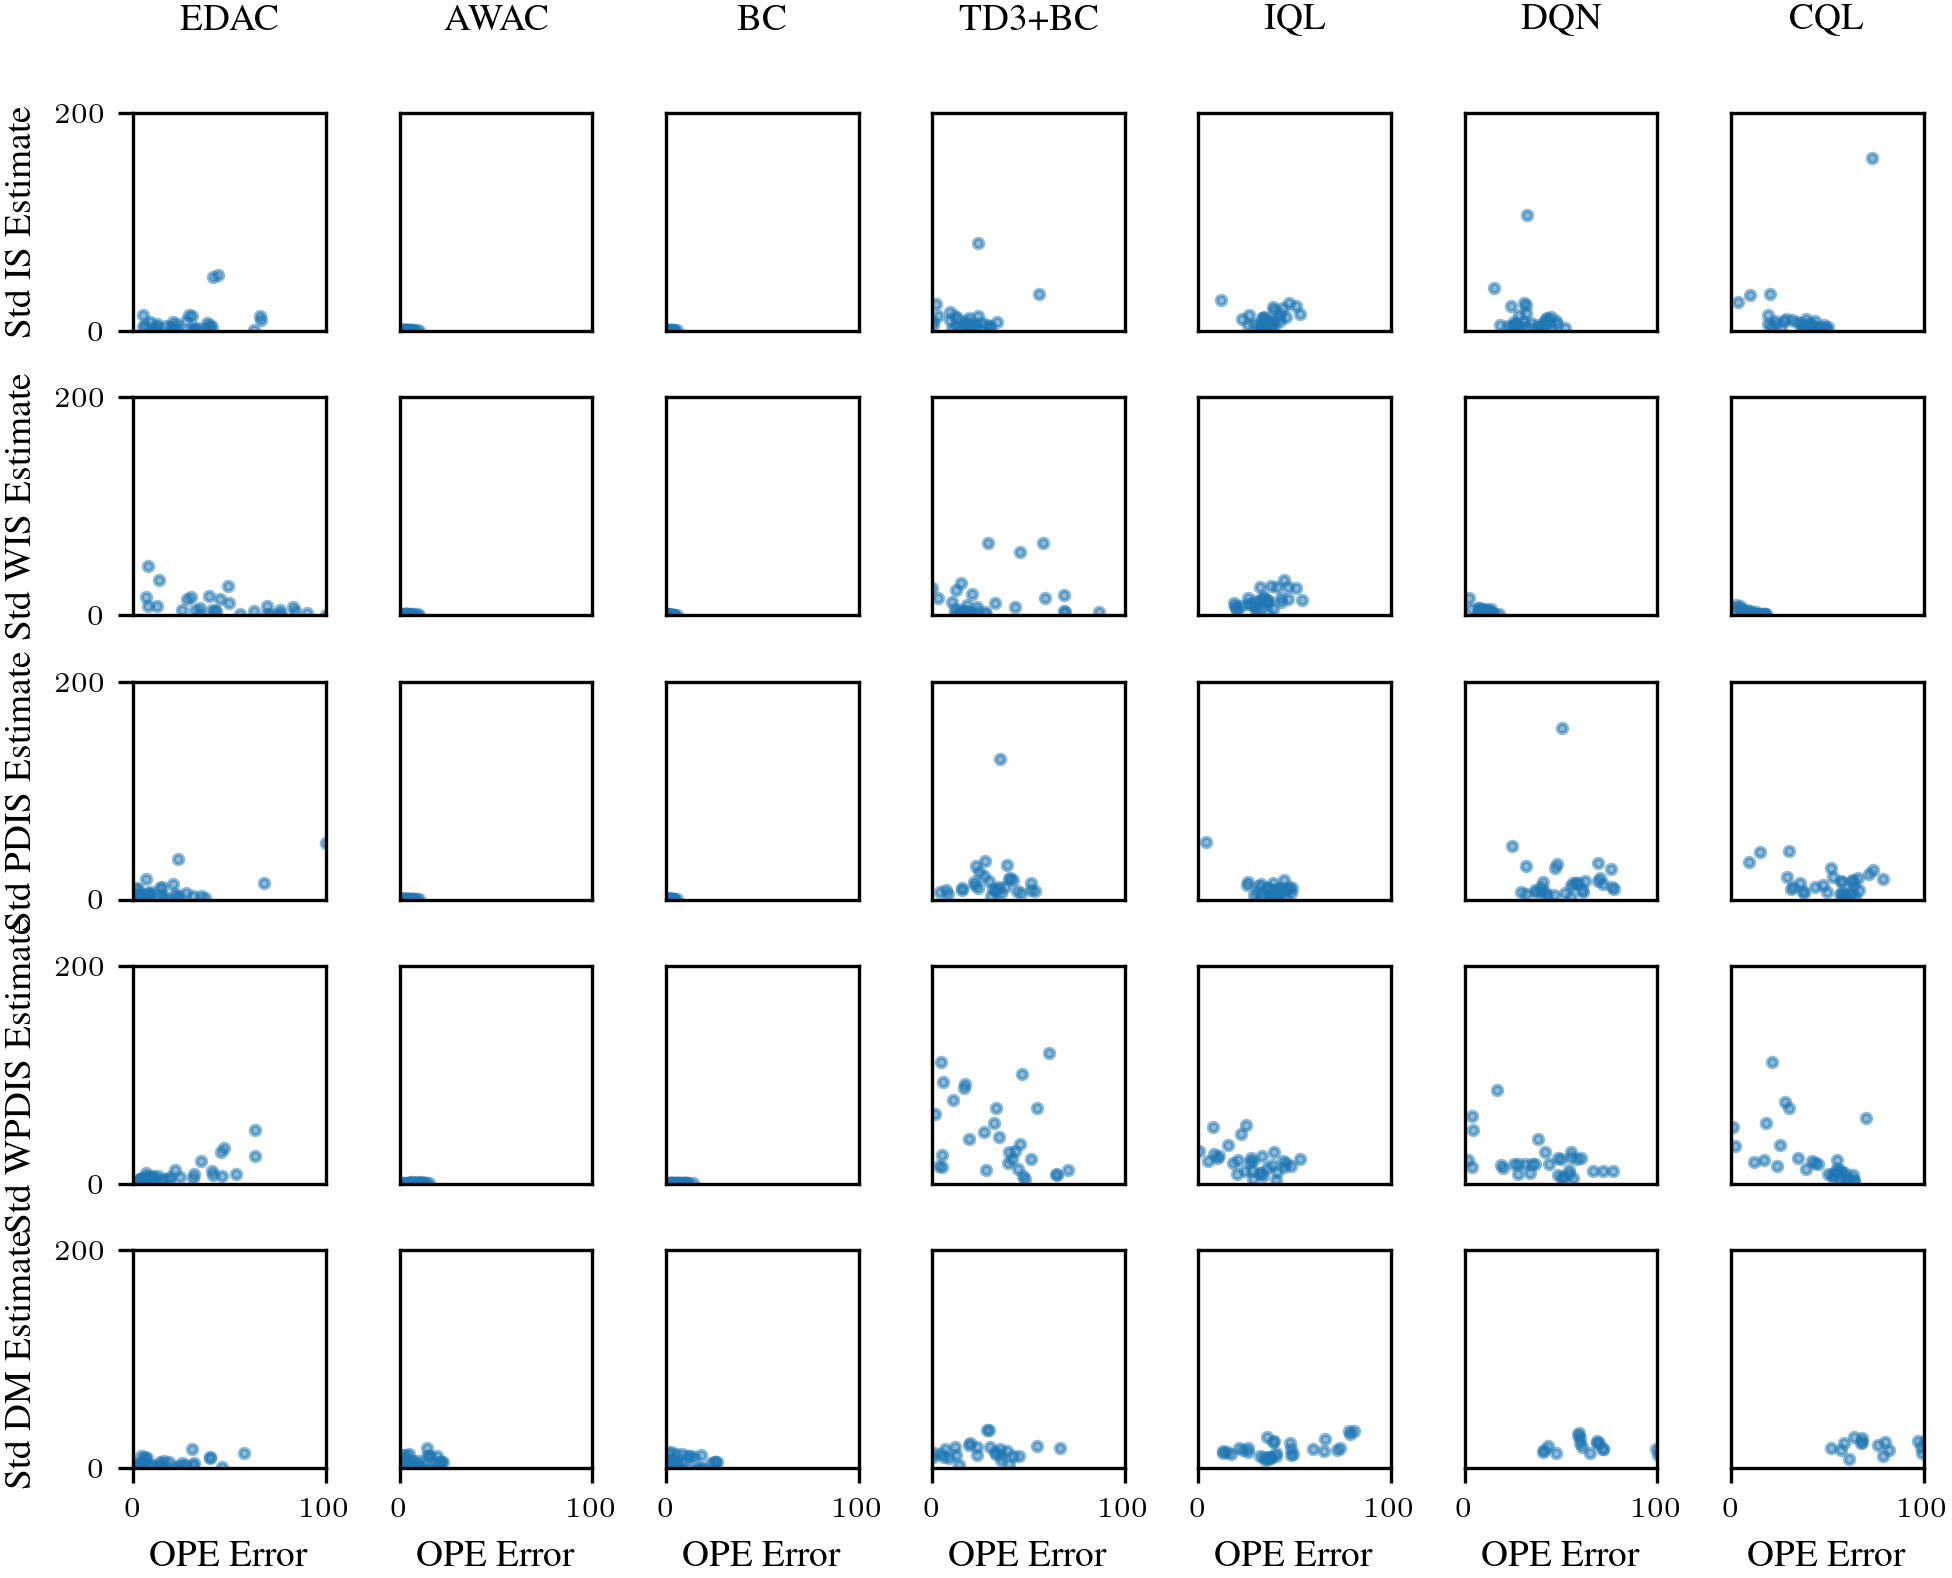

Average RMSE for each model: {'edac': nan, 'awac': nan, 'bc': nan, 'td3_bc': nan, 'iql': nan, 'dqn': nan, 'cql-dqn': nan}


/home/masonhargrave/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/masonhargrave/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [80]:
ope_methods = ["is", "wis", "pdis", "wpdis", "direct"]
ope_labels = ["IS", "WIS", "PDIS", "WPDIS", "DM"]
models = ["edac", "awac", "bc", "td3_bc", "iql", "dqn", "cql-dqn"]
model_labels = ["EDAC", "AWAC", "BC", "TD3+BC", "IQL", "DQN", "CQL"]

# Create a figure with subplots
fig, axes = plt.subplots(
    ncols=len(models), nrows=len(ope_methods), figsize=(6.75, 5.5)
)  # Adjust size as needed

# Initialize a dictionary to store RMSE values for each model
model_rmse = {model: [] for model in models}

# Process data for each model and each OPE method
for col, model in enumerate(models):
    for row, method in enumerate(ope_methods):
        df = pd.read_csv(os.path.join(results_directory, model + "_results.csv"))
        online_error = np.abs(df["mean_return"] - df[f"mean_{method}_estimate"])
        ope_stds = df[f"std_{method}_estimate"]

        # Plot scatter for each method and model
        axes[row, col].scatter(online_error, ope_stds, s=5, alpha=0.5)
        axes[row, col].set_xlim([0, 100])
        axes[row, col].set_ylim([0, 100])
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

for row in range(len(ope_methods)):
    axes[row, 0].set_ylabel("Std " + ope_labels[row] + " Estimate")
    axes[row, 0].set_yticks([0, 200])

for col in range(len(models)):
    axes[0, col].set_title(model_labels[col].upper(), pad=20)
    axes[-1, col].set_xlabel("OPE Error")
    axes[-1, col].xaxis.tick_bottom()
    axes[-1, col].set_xticks([0, 100])

plt.tight_layout()
plt.savefig("ope_std_scatter.pdf")  # Save as high-resolution image
plt.show()

# Calculate and print average RMSE for each model
average_rmse = {model: np.mean(rmses) for model, rmses in model_rmse.items()}
print("Average RMSE for each model:", average_rmse)

/tmp/ipykernel_522139/76332892.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


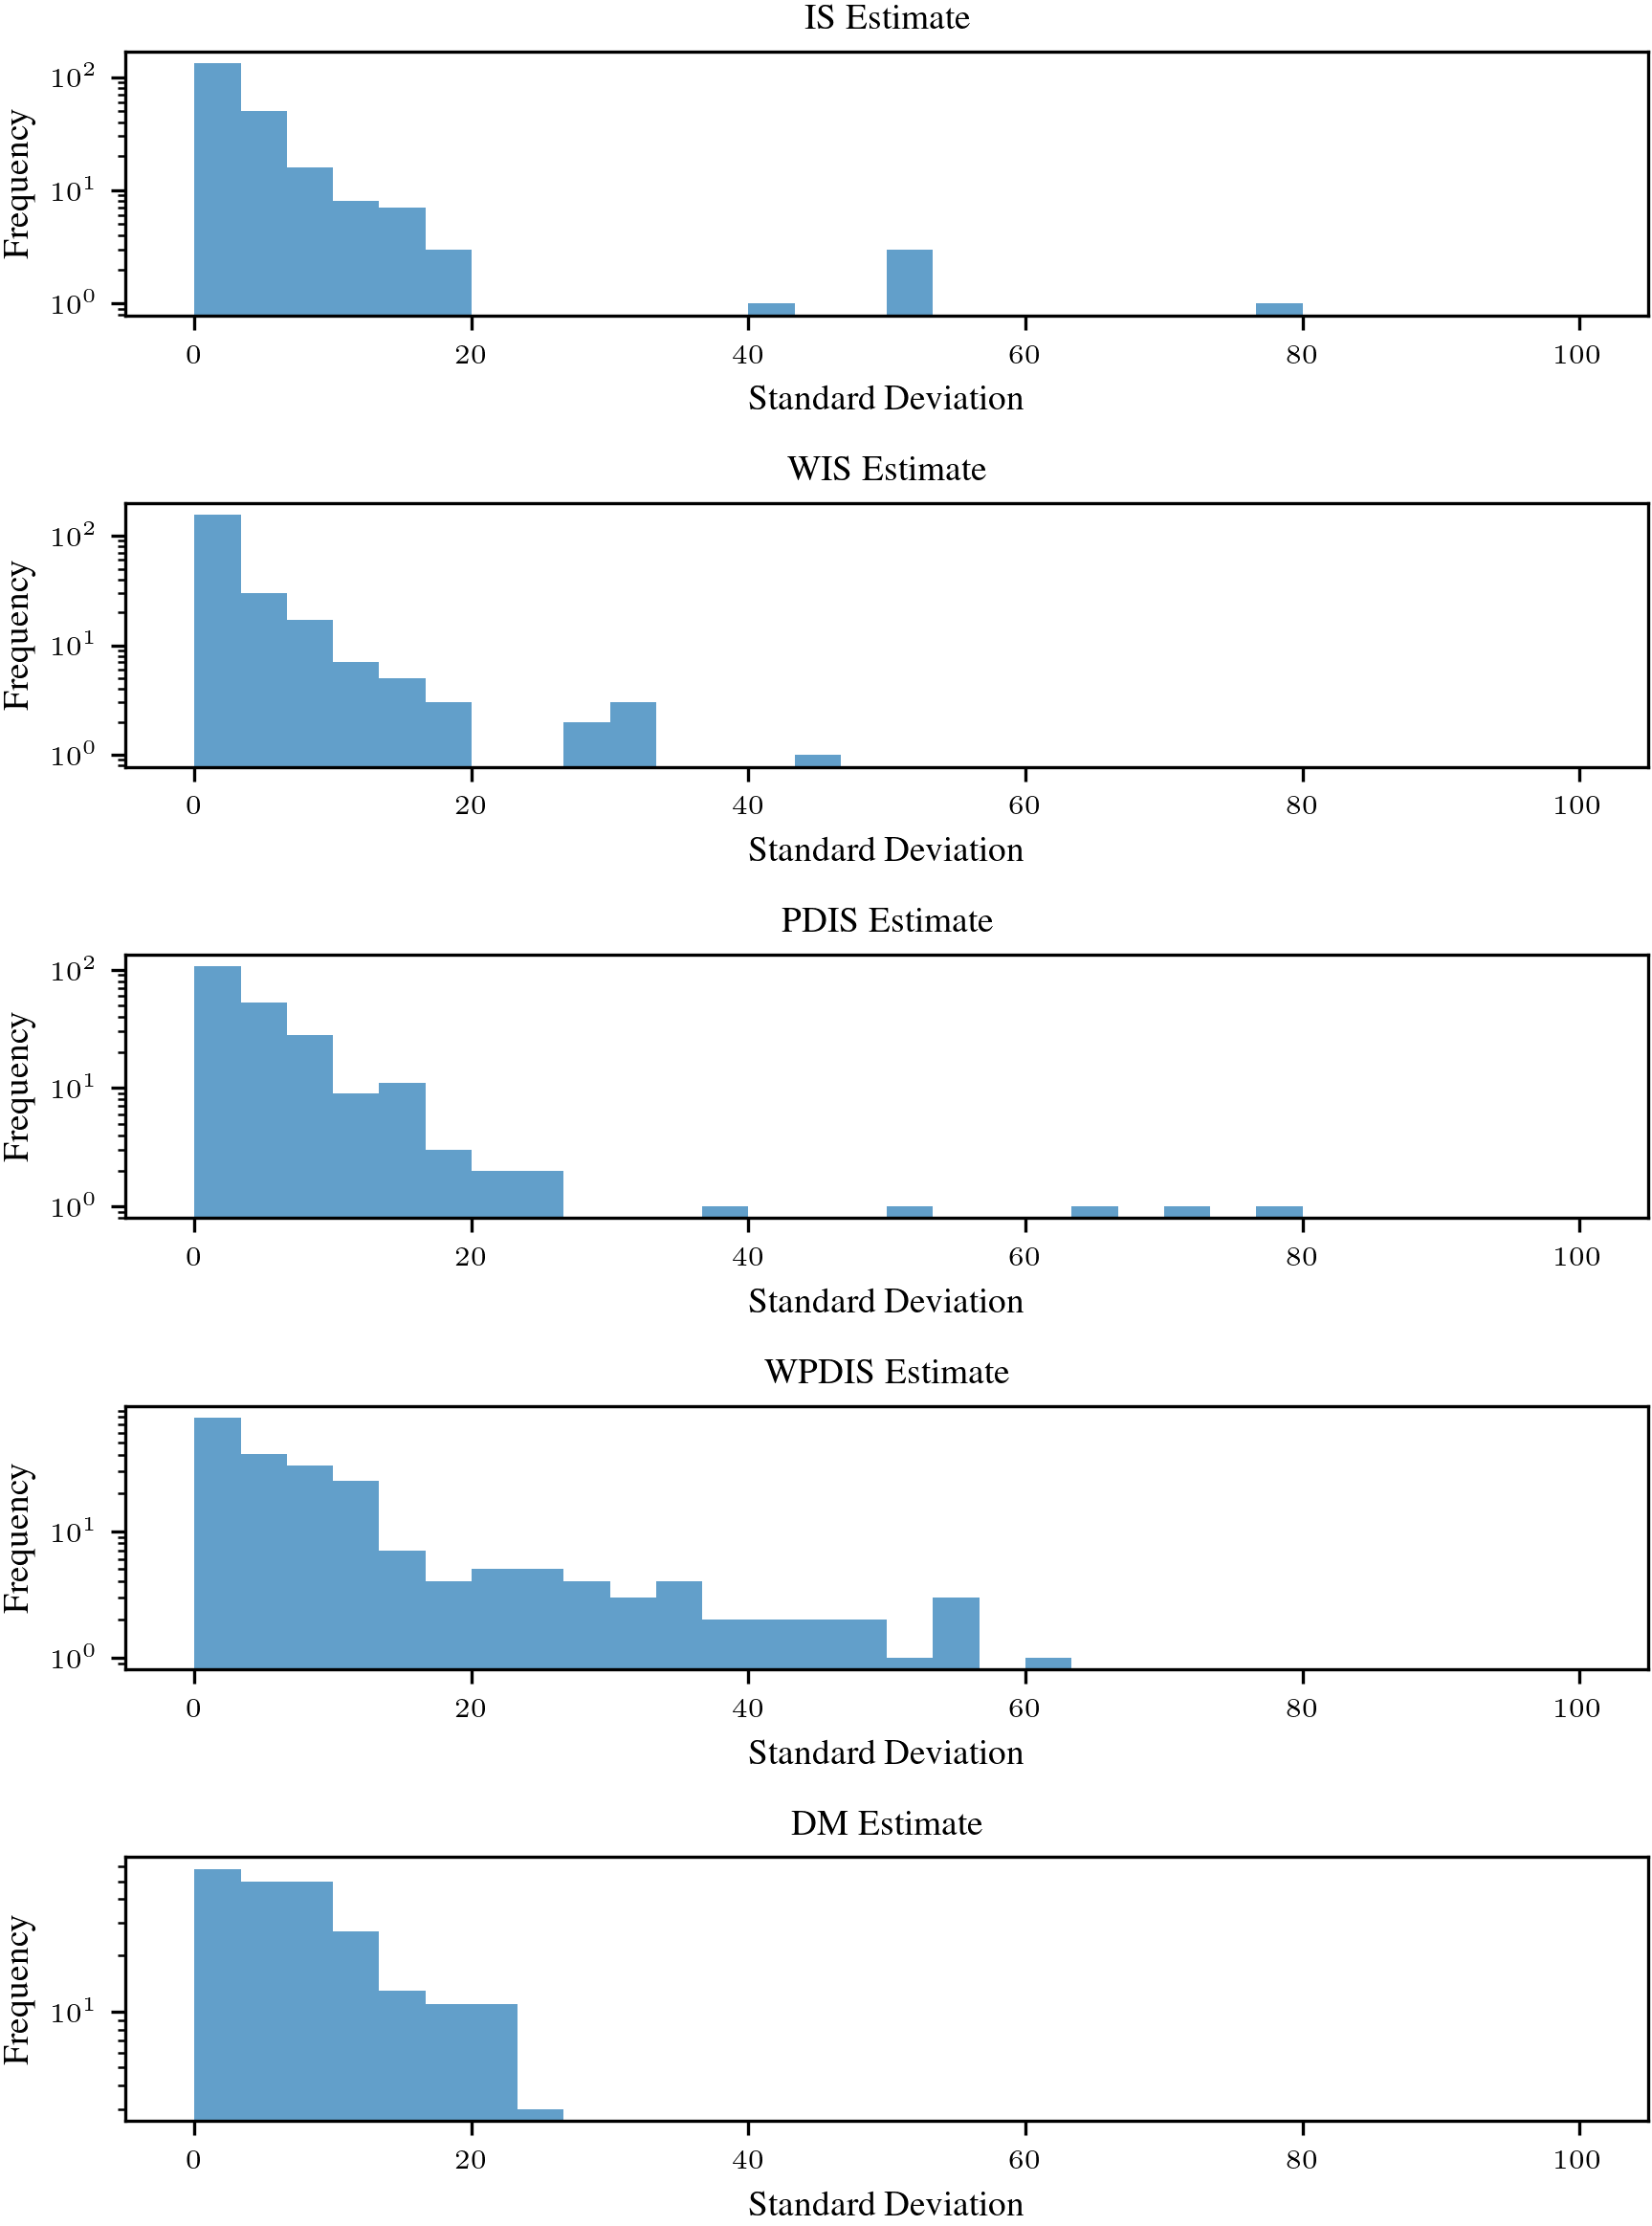

Outliers exceeding the range (0, 100):
OPE Method: IS, Outlier Value: 143.6855191889951
OPE Method: IS, Outlier Value: 458.3439666008281
OPE Method: PDIS, Outlier Value: 116.06629807657862
OPE Method: PDIS, Outlier Value: 692.2079945634305
OPE Method: PDIS, Outlier Value: 110.17796289227874


In [91]:
ope_methods = ["is", "wis", "pdis", "wpdis", "direct"]
ope_labels = ["IS", "WIS", "PDIS", "WPDIS", "DM"]
models = ["edac", "awac", "bc", "td3_bc", "iql", "dqn", "cql-dqn"]
model_labels = ["EDAC", "AWAC", "BC", "TD3+BC", "IQL", "DQN", "CQL"]

# Initialize a dictionary to store the standard deviations for each OPE method
ope_stds_agg = {method: [] for method in ope_methods}
outliers_agg = {method: [] for method in ope_methods}

# Process data for each model and each OPE method
for model in models:
    df = pd.read_csv(os.path.join(results_directory, model + "_results.csv"))
    for method in ope_methods:
        ope_stds = df[f"std_{method}_estimate"]
        ope_stds_agg[method].extend(ope_stds)
        outliers_agg[method].extend(ope_stds[ope_stds > 100])

# Determine the common horizontal range with a cutoff at 100
min_std, max_std = 0, 100

# Create a figure with subplots
fig, axes = plt.subplots(ncols=1, nrows=len(ope_methods), figsize=(6, 8))

# Plot histograms for each OPE method
for idx, method in enumerate(ope_methods):
    axes[idx].hist(
        ope_stds_agg[method], bins=30, alpha=0.7, range=(min_std, max_std), log=True
    )
    axes[idx].set_title(f"{ope_labels[idx]} Estimate")
    axes[idx].set_xlabel("Standard Deviation")
    axes[idx].set_ylabel("Frequency")

plt.tight_layout()
plt.savefig("ope_std_histograms.pdf")  # Save as high-resolution image
plt.show()

# Print all outliers along with the associated OPE method
print("Outliers exceeding the range (0, 100):")
for method in ope_methods:
    for outlier in outliers_agg[method]:
        print(f"OPE Method: {method.upper()}, Outlier Value: {outlier}")

In [75]:
ope_methods = ["is", "wis", "pdis", "wpdis", "direct"]
models = ["edac", "awac", "bc", "td3_bc", "iql", "dqn", "cql-dqn"]
model_labels = ["EDAC", "AWAC", "BC", "TD3+BC", "IQL", "DQN", "CQL"]

# Create a figure with subplots
fig, axes = plt.subplots(
    ncols=len(models), nrows=len(ope_methods), figsize=(6.75, 5.5)
)  # Adjust size as needed

# Initialize a dictionary to store RMSE values for each model
model_rmse = {model: [] for model in models}

# Process data for each model and each OPE method
for col, model in enumerate(models):
    for row, method in enumerate(ope_methods):
        df = pd.read_csv(os.path.join(results_directory, model + "_results.csv"))
        online_means = df["mean_return"]
        ope_means = df[f"mean_{method}_estimate"]

        # Clip the values to be between -100 and 100
        #online_means = np.clip(online_means, -100, 100)
        #ope_means = np.clip(ope_means, -100, 100)

        # Calculate RMSE and store it
        corr = np.corrcoef(online_means, ope_means)[0,1]
        print(model, method, corr)

KeyboardInterrupt: 